In [14]:
# Librairies nécessaires à l'analyse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
import scipy.stats as st
from scipy.stats import pearsonr
from scipy.stats import norm, kstest
import scipy.stats as stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

Projet: Data Analyst au sein d'une grande librairie généraliste en ligne très réputée. J'interviens car l’entreprise souhaite faire le point après deux ans d’exercice, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc...

Données d'entrée: les bases de données (fichiers csv)

Livrable: notebook Jupyter

In [15]:
#import des données
clients = pd.read_csv('customers.csv')
produits = pd.read_csv('products.csv')
transactions = pd.read_csv('transactions.csv')

## Description et analyse du fichier clients :


In [16]:
clients.head()


,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [17]:
clients.describe(include = 'all')


,client_id,sex,birth
count,8623,8623,8623.000000
unique,8623,2,NaN
top,c_4410,f,NaN
freq,1,4491,NaN
mean,NaN,NaN,1978.280877
std,NaN,NaN,16.919535
min,NaN,NaN,1929.000000
25%,NaN,NaN,1966.000000
50%,NaN,NaN,1979.000000
75%,NaN,NaN,1992.000000


In [18]:
clients.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


Description du fichier "clients" : D'après les premières analyses, le fichier client peut être décrit ainsi :
- Pas de doublons : 8623 entrées pour le même nombre de valeurs uniques sur la variable client_id.
- Pas de valeurs nulles : Toutes les entées de chaque colonne sont affectées à une valeur (*.info()*).
- Pas d'outliers : Sur la variable birth les années de naissances s'étendent de 1929 à 2004 ce qui est cohérent.

In [19]:
#valeurs manquantes
clients.isnull().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [20]:
#calcul de l'age à partir de l'année de naissance
clients['Âge']= 2023 - clients['birth']
clients.head()


,client_id,sex,birth,Âge
0,c_4410,f,1967,56
1,c_7839,f,1975,48
2,c_1699,f,1984,39
3,c_5961,f,1962,61
4,c_5320,m,1943,80


In [21]:
# Définition de l'âge moyen des Femmes et des Hommes
age_femme = clients.loc[clients["sex"]=="f"]["Âge"].mean()
age_homme = clients.loc[clients["sex"]=="m"]["Âge"].mean()
print("L'âge des Femmes moyen est de :", int(age_femme),"ans")
print("L'âge des Hommes moyen est de :", int(age_homme),"ans")

L'âge des Femmes moyen est de : 45 ans
L'âge des Hommes moyen est de : 44 ans


In [22]:
#Création d'une table avec la répartition des âges en fonction du sexe du client
graph = clients.groupby("Âge")[["sex"]].value_counts()
graph = graph.to_frame().reset_index()
graph = graph.pivot(columns="sex", index="Âge")[[0]].reset_index()
graph

Âge    0     
sex        f    m
0    19  232  208
1    20   65   81
2    21   66   80
3    22   72   57
4    23   78   58
..   ..  ...  ...
71   90    5    3
72   91    5    1
73   92    2    2
74   93    3    1
75   94    1    2

[76 rows x 3 columns]

## Description et analyse du fichier produits :


In [23]:
produits.head()


,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [24]:
produits.describe(include = 'all')


,id_prod,price,categ
count,3287,3287.000000,3287.000000
unique,3287,NaN,NaN
top,0_1421,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.856641,0.370246
std,NaN,29.847908,0.615387
min,NaN,-1.000000,0.000000
25%,NaN,6.990000,0.000000
50%,NaN,13.060000,0.000000
75%,NaN,22.990000,1.000000


In [25]:
produits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [356]:
produits.shape

(3287, 3)

In [27]:
#vérification des prix inférieurs à 0
produits[produits['price'] < 0]


,id_prod,price,categ
731,T_0,-1.0,0


Description du fichier "produits" : D'après les premières analyses, le fichier produits peut être décrit ainsi :
- Pas de doublons : 3287 entrées pour le même nombre de valeurs uniques sur la variable id_prod.
- Pas de valeurs nulles : Toutes les entées de chaque colonne sont affectées à une valeur (*.info()*).
- Outliers : 1 produit a une valeur négative : T_0. Ce n'est pas incohérent il peut s'agir par exemple d'une remise ou d'un produit test.

L'analyse du ficihier Transactions nous montre que les produits dont le prix est inférieur à 0 sont des produits tests. Nous allons donc remplacer ses prix par 0

In [28]:
#remplacement des prix négatifs par 0 avec la méthode clip
produits['price']=produits['price'].clip(lower=0)

In [29]:
#valeurs manquantes
produits.isnull().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [30]:
produits[["price"]].describe()


,price
count,3287.000000
mean,21.856946
std,29.847680
min,0.000000
25%,6.990000
50%,13.060000
75%,22.990000
max,300.000000


#### Recherche des valeurs aberrantes


In [31]:
# Calcul du premier quartile
q1= np.percentile(produits['price'],25)
print("Q1=", q1, " ")

# Calcul du troisième quartile
q3= np.percentile(produits['price'],75)
print("Q3=", q3, " ")

# Calcul de l'inter-quartile
iqr=q3-q1
print("IQR=",iqr," ")

# Calcul de la borne inférieure
lower_bound = q1 -(1.5 * iqr)
print("lower_bound=",lower_bound," ")

# Calcul de la borne supérieure
upper_bound = q3 +(1.5 * iqr)
print("upper_bound=",upper_bound," ")



Q1= 6.99  
Q3= 22.99  
IQR= 15.999999999999998  
lower_bound= -17.009999999999998  
upper_bound= 46.989999999999995  


In [32]:
# Recherche des outliers
outliers = produits[(produits['price'] > upper_bound) | (produits['price'] < lower_bound)]
print("Le nombre total de valeurs aberrantes est de :", outliers['price'].count())
outliers['price']

Le nombre total de valeurs aberrantes est de : 302


10      225.17
11       51.92
38       72.11
49       47.22
64      107.99
         ...  
3267     63.99
3269     51.99
3271    147.99
3279     55.99
3282    115.99
Name: price, Length: 302, dtype: float64

Nous avons 302 outliers dans ce Df

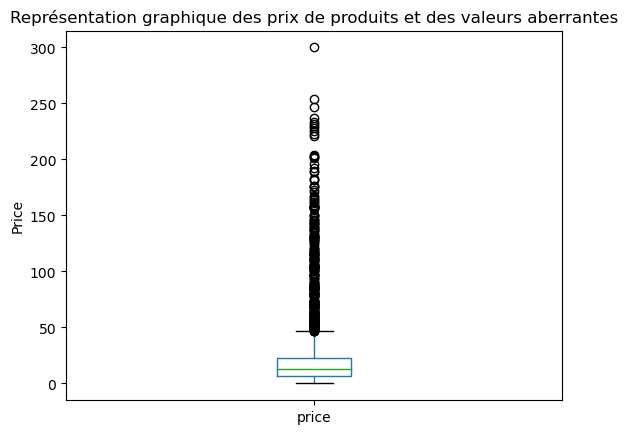

In [33]:
#Représentation graphique
produits.boxplot(column =['price'],grid = False) 
plt.title('Représentation graphique des prix de produits et des valeurs aberrantes')
plt.ylabel('Price')
plt.show()

## Description et analyse du fichier transactions :


In [34]:
transactions.head()


,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [35]:
transactions.shape


(679532, 4)

In [36]:
transactions.describe(include = 'all')


,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


In [37]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


On remarque dans le *describe()* que des dates sont identifiées comme *test*. Regardons ces lignes de plus près :

Traitement : Nous allons donc convertir les données de l'attribut date au format date.
Les données qui ne sont pas considérées comme telles seront marquées comme nulles.

In [38]:
#valeurs manquantes
transactions.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

In [39]:
# La variable 'date' affiche des valeurs qui sont atypiques

transactions.loc[transactions['session_id']=='s_0']


,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


Il y'a 200 lignes qui sont des sessions test que nous converserons dans le dataframe transactions_test

In [40]:
transactions.loc[transactions['session_id']=='s_1']


,id_prod,date,session_id,client_id
480642,0_1259,2021-03-01 00:01:07.843138,s_1,c_329


In [41]:
#nouveau df sans les transactions "test"
transactions1 = transactions.loc[transactions['session_id']!='s_0'].reset_index()
transactions1.head()

,index,id_prod,date,session_id,client_id
0,0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [42]:
#changement de type date
transactions1['date'] = pd.to_datetime(transactions1['date'], errors = 'coerce')
transactions1

,index,id_prod,date,session_id,client_id
0,0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232
...,...,...,...,...,...
679327,679527,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489
679328,679528,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370
679329,679529,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304
679330,679530,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227


In [43]:
#vérification
transactions1.dtypes

index                  int64
id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object

In [44]:
transactions1.describe(include = 'all')


,index,id_prod,date,session_id,client_id
count,679332.000000,679332,679332,679332,679332
unique,NaN,3266,679332,342315,8600
top,NaN,1_369,2022-05-20 13:21:29.043970,s_118668,c_1609
freq,NaN,2252,1,14,25488
first,NaN,NaN,2021-03-01 00:01:07.843138,NaN,NaN
last,NaN,NaN,2023-02-28 23:58:30.792755,NaN,NaN
mean,339765.256134,NaN,NaN,NaN,NaN
std,196166.053457,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN
25%,169877.750000,NaN,NaN,NaN,NaN


In [45]:
transactions1['date_day'] = transactions1['date'].dt.day
transactions1['date_month'] = transactions1['date'].dt.month
transactions1['date_year'] = transactions1['date'].dt.year

In [46]:
transactions1

,index,id_prod,date,session_id,client_id,date_day,date_month,date_year
0,0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,20,5,2022
1,1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2,2,2022
2,2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,18,6,2022
3,3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,24,6,2021
4,4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,11,1,2023
...,...,...,...,...,...,...,...,...
679327,679527,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,15,1,2022
679328,679528,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,19,3,2022
679329,679529,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,20,12,2022
679330,679530,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,16,7,2021


In [47]:
#Création de la colonne 'année-mois'

transactions1['year-month'] = transactions1['date_year'].astype(str)+ "-" + transactions1['date_month'].astype(str)
transactions1

,index,id_prod,date,session_id,client_id,date_day,date_month,date_year,year-month
0,0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,20,5,2022,2022-5
1,1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2,2,2022,2022-2
2,2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,18,6,2022,2022-6
3,3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,24,6,2021,2021-6
4,4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,11,1,2023,2023-1
...,...,...,...,...,...,...,...,...,...
679327,679527,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,15,1,2022,2022-1
679328,679528,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,19,3,2022,2022-3
679329,679529,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,20,12,2022,2022-12
679330,679530,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,16,7,2021,2021-7


In [48]:
#suppression des colonnes maintenant inutiles
transactions2=transactions1.drop(columns=['index'])
transactions2

,id_prod,date,session_id,client_id,date_day,date_month,date_year,year-month
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,20,5,2022,2022-5
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2,2,2022,2022-2
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,18,6,2022,2022-6
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,24,6,2021,2021-6
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,11,1,2023,2023-1
...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,15,1,2022,2022-1
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,19,3,2022,2022-3
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,20,12,2022,2022-12
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,16,7,2021,2021-7


In [49]:
# Affichage des différentes valeurs de la variable année
df = transactions2["date_year"].value_counts().to_frame().reset_index()
df["% des transactions"] = round(df["date_year"]/df["date_year"].sum(),3)*100
df = df.rename(columns={"index":"Année", "date_year":"Nb de transactions", "% des transactions":"Répartition en %"})
df
# On constate qu'il existe une année 2023. On considére donc que nous sommes en 2023.

,Année,Nb de transactions,Répartition en %
0,2022,346500,51.0
1,2021,278335,41.0
2,2023,54497,8.0


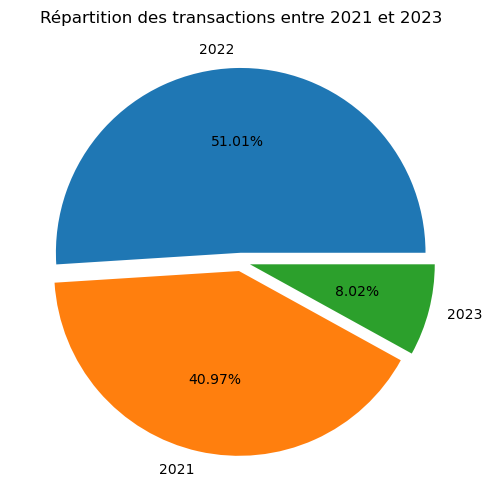

In [50]:
# Affichage du graphique des répartitions des transactions
plt.figure(figsize=(10,6))
plt.pie(df["Nb de transactions"], labels=("2022", "2021","2023"), explode=(0.05, 0.05, 0.05), autopct="%.2f%%")
plt.title("Répartition des transactions entre 2021 et 2023")


plt.show()

In [51]:
#ajout des infos du produit (prix et categ) pour chaque ligne de transactions du df transac par une fusion gauche
## Jointure entre transactions2 et produits

transac_prod=pd.merge(transactions2, produits, on='id_prod', how='left', indicator=True)
transac_prod

,id_prod,date,session_id,client_id,date_day,date_month,date_year,year-month,price,categ,_merge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,20,5,2022,2022-5,4.18,0.0,both
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2,2,2022,2022-2,15.99,1.0,both
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,18,6,2022,2022-6,7.99,0.0,both
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,24,6,2021,2021-6,69.99,2.0,both
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,11,1,2023,2023-1,4.99,0.0,both
...,...,...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,15,1,2022,2022-1,12.99,0.0,both
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,19,3,2022,2022-3,10.99,1.0,both
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,20,12,2022,2022-12,12.99,0.0,both
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,16,7,2021,2021-7,4.98,0.0,both


In [52]:
#Stockage des valeurs ayant trouvés une correspondance dans la jointure entre les dataframes transactions2 et produits
transac_prod1= transac_prod.loc[transac_prod['_merge']== "both"]
transac_prod1.shape

(679111, 11)

In [53]:
#Stockage des valeurs qui n'ont pas trouvé de correspondance lors de la jointure entre les dataframes transactions2 et products
transac_prod3= transac_prod.loc[transac_prod['_merge']!= "both"]
transac_prod3.shape

(221, 11)

In [54]:
# Identification du type de jointure où certaines lignes n'ont pas trouvé de correspondance
transac_prod2= transac_prod.loc[transac_prod['_merge']== "left_only"]
transac_prod2.shape

(221, 11)

In [55]:
transac_prod4= transac_prod.loc[transac_prod['_merge']== "right_only"]
transac_prod4.shape

(0, 11)

Nous constatons que la jointure pour laquelle il n'y a pas eu correspondance sur toutes les lignes est de type 'left_only'. Ce qui nous permet de conclure que tous les 'id_prod' du dataframe transactions2, n'ont pas trouvé de correspondance dans le 'id_prod' du dataframe produits.

In [56]:
#Observation des valeurs NaN de la colonne ['price'] par la création d'un nouveau dataframe 
transac_prod_null=transac_prod[transac_prod['price'].isna()]
transac_prod_null

,id_prod,date,session_id,client_id,date_day,date_month,date_year,year-month,price,categ,_merge
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,23,9,2022,2022-9,NaN,NaN,left_only
10103,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,23,7,2022,2022-7,NaN,NaN,left_only
11723,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,3,12,2022,2022-12,NaN,NaN,left_only
15670,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,16,8,2021,2021-8,NaN,NaN,left_only
16372,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,16,7,2022,2022-7,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...
669533,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,25,8,2021,2021-8,NaN,NaN,left_only
670484,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,6,3,2022,2022-3,NaN,NaN,left_only
671088,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,16,5,2022,2022-5,NaN,NaN,left_only
675480,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,11,2,2022,2022-2,NaN,NaN,left_only


In [57]:
#quelles sont les produits sans prix?
transac_prod[transac_prod['price'].isna()]['id_prod'].unique()

array(['0_2245'], dtype=object)

Un seul produit concerné, qui a été vendu 221 fois, on ne peut exclure cet article et les transactions associées. Je vais

estimer son prix comme étant la moyenne des prix des produits.
déterminer sa categorie d'après son id qui commence par zéro ce qui indique sa catégorie

In [58]:
#calcul du prix moyen de la categorie 0
produits[produits.categ==0].mean()['price']


11.727713295799047

In [59]:
#remplacement de la valeur Nan par le prix moyen
produits1 = produits.append({'id_prod':'0_2245', 'price':produits[produits.categ==0].mean()['price'], 'categ':0}, ignore_index=True)
produits1

,id_prod,price,categ
0,0_1421,19.990000,0
1,0_1368,5.130000,0
2,0_731,17.990000,0
3,1_587,4.990000,1
4,0_1507,3.990000,0
...,...,...,...
3283,0_146,17.140000,0
3284,0_802,11.220000,0
3285,1_140,38.560000,1
3286,0_1920,25.160000,0


In [60]:
produits1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3288 non-null   object 
 1   price    3288 non-null   float64
 2   categ    3288 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


il n'y'a plus de valeurs nulles

In [61]:
# Nous allons effectuer à nouveau notre jointure entre transactions1 et produits
transac_prod_final=pd.merge(transactions2, produits1, on='id_prod', how='left', indicator=True)
transac_prod_final

,id_prod,date,session_id,client_id,date_day,date_month,date_year,year-month,price,categ,_merge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,20,5,2022,2022-5,4.18,0,both
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2,2,2022,2022-2,15.99,1,both
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,18,6,2022,2022-6,7.99,0,both
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,24,6,2021,2021-6,69.99,2,both
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,11,1,2023,2023-1,4.99,0,both
...,...,...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,15,1,2022,2022-1,12.99,0,both
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,19,3,2022,2022-3,10.99,1,both
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,20,12,2022,2022-12,12.99,0,both
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,16,7,2021,2021-7,4.98,0,both


In [62]:
#Vérification des valeurs qui ont trouvé de correspondance lors de la jointure entre les dataframes transactions2 et produits
transac_prod_final= transac_prod_final.loc[transac_prod_final['_merge']== "both"]
transac_prod_final.shape

(679332, 11)

Nous observons que toutes les valeurs des deux dataframes utilsés pour la jointure ont trouvé correspondance.


In [63]:
#Stockage des valeurs qui n'ont pas trouvé de correspondance lors de la jointure entre les dataframes transactions2 et produits

transac_prod_final.loc[transac_prod_final['_merge']!= "both"]


,id_prod,date,session_id,client_id,date_day,date_month,date_year,year-month,price,categ,_merge


In [64]:
transac_prod_final.loc[transac_prod_final['_merge']== "left_only"]


,id_prod,date,session_id,client_id,date_day,date_month,date_year,year-month,price,categ,_merge


# PARTIE 1: Indicateurs et graphes autour du chiffre d'affaire


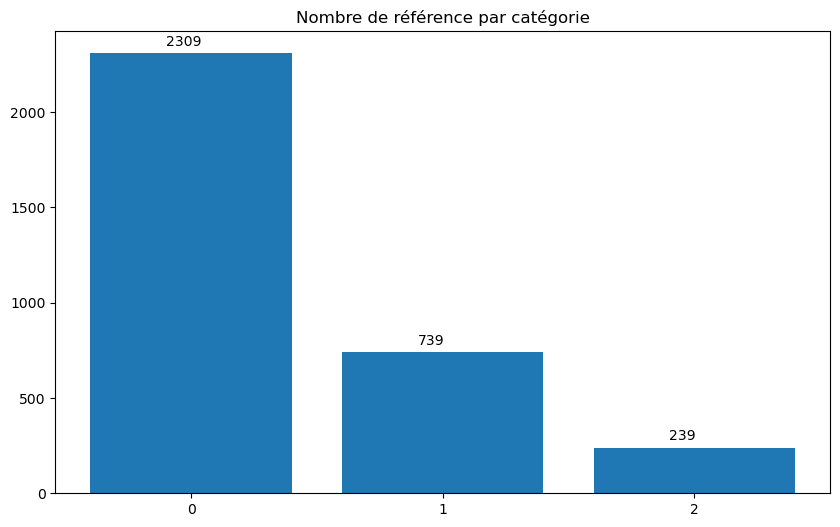

In [65]:
#Création du df qui va nous servir à afficher les références par catégorie
graph = produits.groupby("categ")[["id_prod"]].count().reset_index()
# Mise en forme Graphique
plt.figure(figsize=(10,6))
plt.bar(x=graph["categ"], height=graph["id_prod"])
plt.xticks(np.arange(min(graph["categ"]),max(graph["categ"])+1, step=1))
plt.title("Nombre de référence par catégorie")

values=graph["id_prod"].to_list()
for i in range(3):
    plt.text(i-0.1, values[i]+40, values[i])

plt.show()

In [66]:
import seaborn as sns


In [67]:
# création nouvelle colonne mois de la session
transac_prod_final['mois_session']= transac_prod_final['date'].dt.strftime('%Y-%m')

In [68]:
transac_prod_final

,id_prod,date,session_id,client_id,date_day,date_month,date_year,year-month,price,categ,_merge,mois_session
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,20,5,2022,2022-5,4.18,0,both,2022-05
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2,2,2022,2022-2,15.99,1,both,2022-02
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,18,6,2022,2022-6,7.99,0,both,2022-06
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,24,6,2021,2021-6,69.99,2,both,2021-06
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,11,1,2023,2023-1,4.99,0,both,2023-01
...,...,...,...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,15,1,2022,2022-1,12.99,0,both,2022-01
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,19,3,2022,2022-3,10.99,1,both,2022-03
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,20,12,2022,2022-12,12.99,0,both,2022-12
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,16,7,2021,2021-7,4.98,0,both,2021-07


In [69]:
#pour obtenir le CA par mois, j'effectue une agregation
CA_mensuel = transac_prod_final.groupby(transac_prod_final['mois_session'])['price'].sum().reset_index(name='CA')
CA_mensuel.head()

,mois_session,CA
0,2021-03,482546.159420
1,2021-04,476273.487986
2,2021-05,493037.291706
3,2021-06,484170.653993
4,2021-07,482882.310853


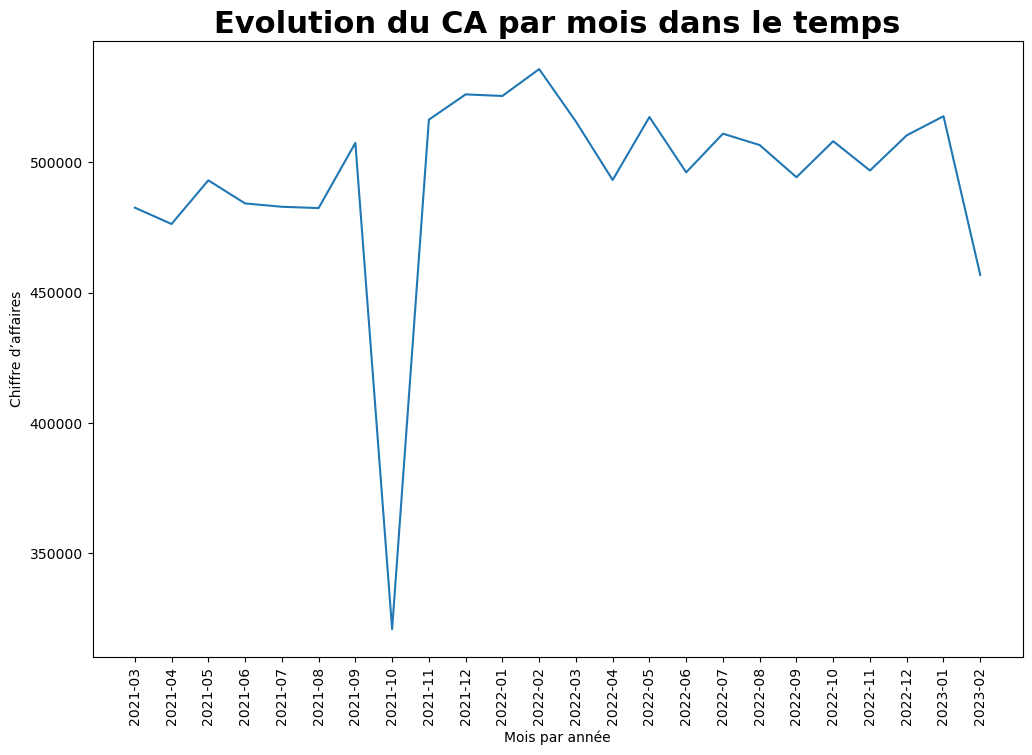

In [70]:
# Visualisation de l'évolution du chiffre d'affaires dans le temps
fig = plt.figure(figsize=(12,8))
ax = plt.axes()
plt.plot(CA_mensuel['mois_session'], CA_mensuel['CA'])
plt.xticks(rotation=90)
plt.title("Evolution du CA par mois dans le temps", fontsize=22, fontweight='bold')
ax = ax.set(xlabel="Mois par année", ylabel="Chiffre d’affaires")
plt.show()

Chute du CA en oct 2021 ==> à analyser

Zoom sur les evenements d'octobre 2021. Visualisation du CA hebdo

In [71]:
# création nouvelle colonne semaine de la session
transac_prod_final['semaine_session']= transac_prod_final['date'].dt.strftime('%Y-%W')
#agregation sur la semaine du CA réalisé
CA_hebdo = transac_prod_final.groupby(transac_prod_final['semaine_session'])['price'].sum().reset_index(name='CA')
CA_hebdo.head()

,semaine_session,CA
0,2021-09,110498.463140
1,2021-10,105693.240000
2,2021-11,112059.080000
3,2021-12,109476.253140
4,2021-13,107954.298566


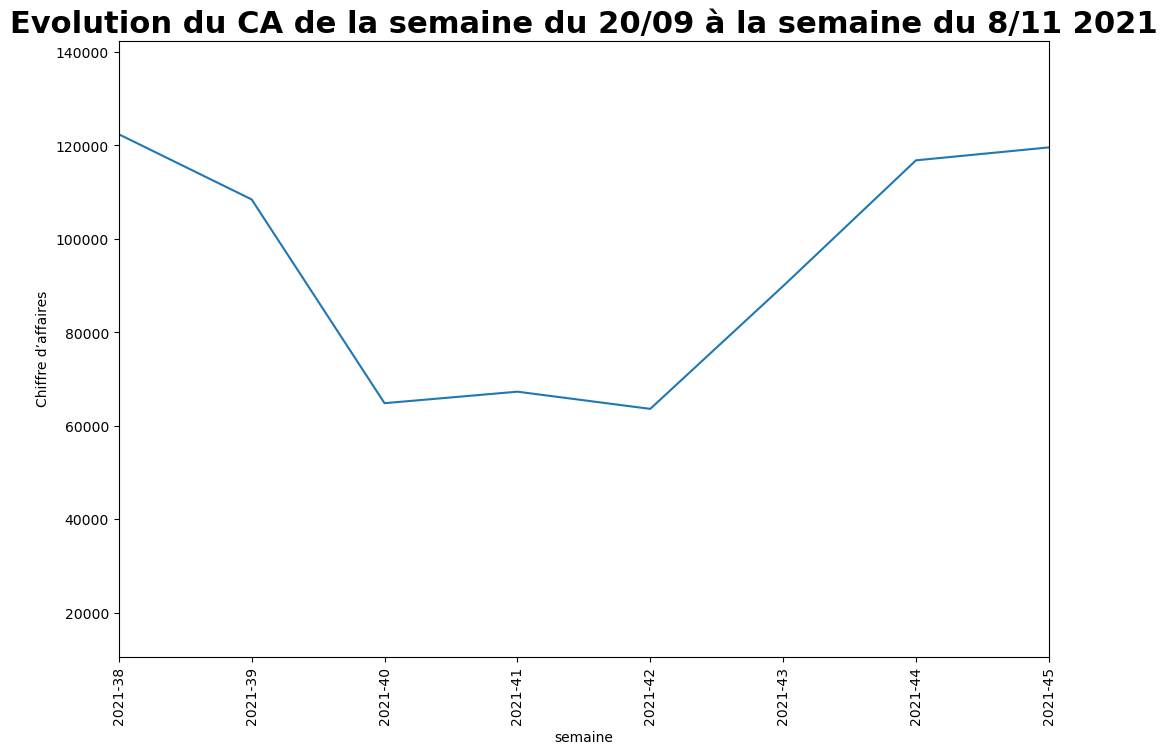

In [72]:
#visualisation du CA hebdo de fin sept à debut nov 2021
fig = plt.figure(figsize=(12,8))
ax = plt.axes()
plt.plot(CA_hebdo['semaine_session'], CA_hebdo['CA'])
plt.xticks(rotation=90)
plt.xlim('2021-38', '2021-45')
plt.title("Evolution du CA de la semaine du 20/09 à la semaine du 8/11 2021", fontsize=22, fontweight='bold')
ax = ax.set(xlabel="semaine", ylabel="Chiffre d’affaires")
plt.show()

Je continue à zoomer à la journée. et si rien de visible alors pb sur les produits



In [73]:
# création nouvelle colonne jour de la session
transac_prod_final['jour_session']= transac_prod_final['date'].dt.strftime('%Y-%m-%d')
#agregation sur la journée du CA réalisé
CA_jour = transac_prod_final.groupby(transac_prod_final['jour_session'])['price'].sum().reset_index(name='CA')
CA_jour.head()

,jour_session,CA
0,2021-03-01,16576.947713
1,2021-03-02,15498.177713
2,2021-03-03,15198.690000
3,2021-03-04,15196.070000
4,2021-03-05,17471.370000


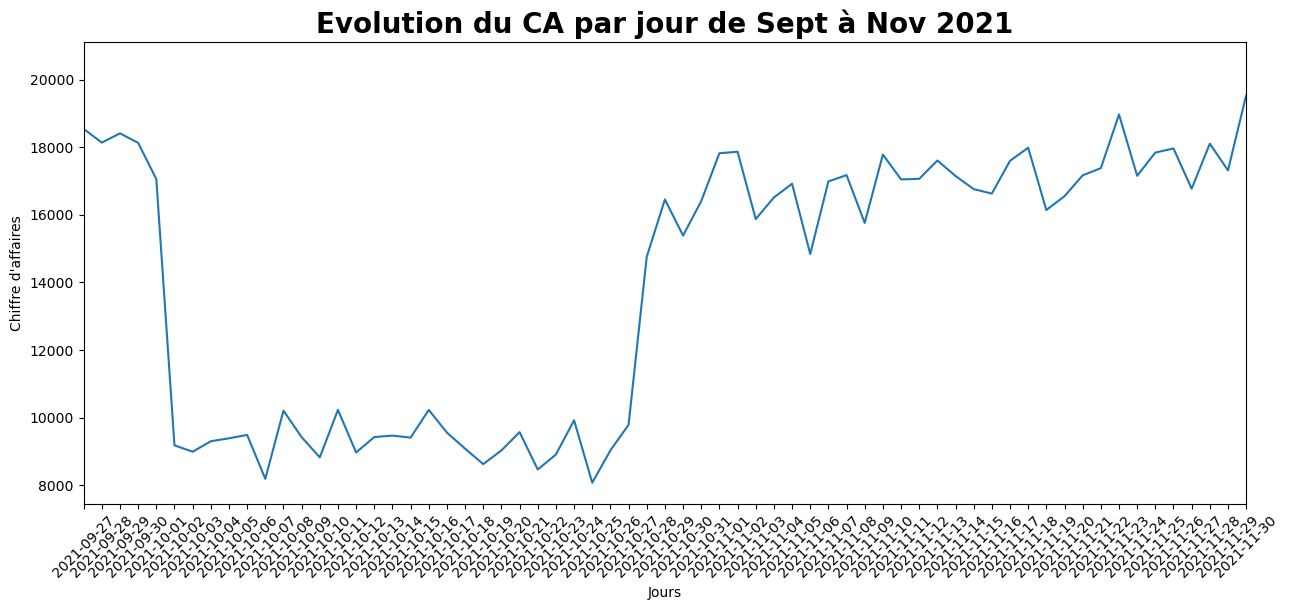

In [74]:
#Représentation graphique de l'évolution quotidienne du chiffre d'affaires de Septembre à Novembre 2021.
fig = plt.figure(figsize=(15,6))
ax = plt.axes()
plt.plot(CA_jour['jour_session'], CA_jour['CA'])
plt.xticks(rotation=45)
plt.xlim('2021-09-27', '2021-11-30')
plt.title("Evolution du CA par jour de Sept à Nov 2021", fontsize=20, fontweight='bold')
ax = ax.set(xlabel="Jours", ylabel="Chiffre d'affaires")
plt.show()

La baisse des ventes en CA est sur toute une période allant du 01/10 au 26/10 inclus. Je regarde comment sont répartis les produits par catégorie sur cette période.



In [75]:
#afficher le ca par categ par mois
CA_cat=transac_prod_final.groupby(['mois_session', 'categ']).sum()[['price']]

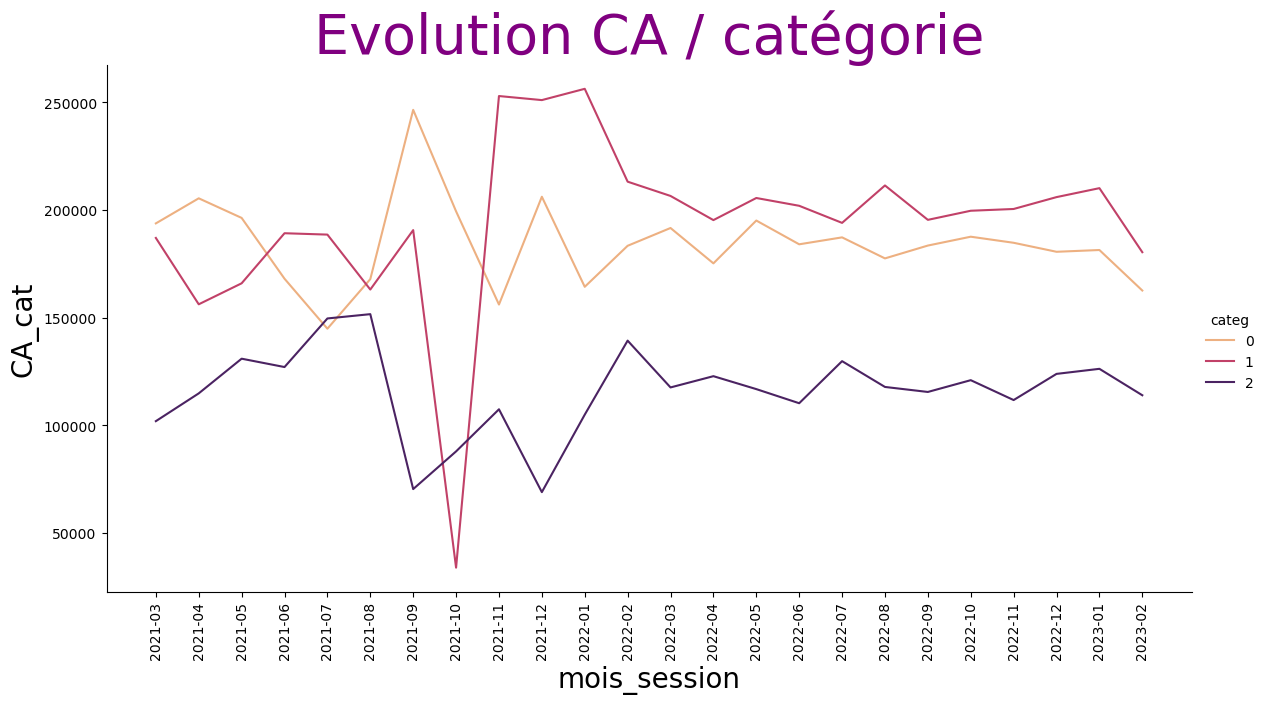

In [357]:
# evolution du ca par categorie supperposé 3 graph(3 categ)
sns.relplot(
    data=CA_cat,
    x='mois_session', y='price',
    hue='categ',
    kind='line',
    palette = 'flare',
    height=6, aspect=2)
plt.title('Evolution CA / catégorie', fontsize=40, color='purple')
plt.xlabel('mois_session', size = 20)
plt.ylabel('CA_cat', size = 20)
plt.xticks(size = 10, rotation=90)
plt.yticks(size = 10)
plt.show()

Nous remarquons que le CA de la categ 1 a baissé au mois d'octobre, ce qui pourrait justifier la baisse du CA au mois d'octobre.

In [77]:
#df sans les transactions d'octobre
df_transactions = transac_prod_final.drop(transac_prod_final[(transac_prod_final['mois_session'] == '2021-10')].index)
df_transactions

,id_prod,date,session_id,client_id,date_day,date_month,date_year,year-month,price,categ,_merge,mois_session,semaine_session,jour_session
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,20,5,2022,2022-5,4.18,0,both,2022-05,2022-20,2022-05-20
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2,2,2022,2022-2,15.99,1,both,2022-02,2022-05,2022-02-02
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,18,6,2022,2022-6,7.99,0,both,2022-06,2022-24,2022-06-18
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,24,6,2021,2021-6,69.99,2,both,2021-06,2021-25,2021-06-24
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,11,1,2023,2023-1,4.99,0,both,2023-01,2023-02,2023-01-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,15,1,2022,2022-1,12.99,0,both,2022-01,2022-02,2022-01-15
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,19,3,2022,2022-3,10.99,1,both,2022-03,2022-11,2022-03-19
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,20,12,2022,2022-12,12.99,0,both,2022-12,2022-51,2022-12-20
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,16,7,2021,2021-7,4.98,0,both,2021-07,2021-28,2021-07-16


In [78]:
octobre = transac_prod_final.loc[transac_prod_final['mois_session'] == '2021-10']
octobre


,id_prod,date,session_id,client_id,date_day,date_month,date_year,year-month,price,categ,_merge,mois_session,semaine_session,jour_session
68,0_1409,2021-10-02 17:39:26.919537,s_99013,c_5725,2,10,2021,2021-10,4.99,0,both,2021-10,2021-39,2021-10-02
71,0_1247,2021-10-03 16:05:12.544172,s_99443,c_3394,3,10,2021,2021-10,15.99,0,both,2021-10,2021-39,2021-10-03
80,0_1272,2021-10-13 14:35:01.163737,s_104207,c_8534,13,10,2021,2021-10,17.01,0,both,2021-10,2021-41,2021-10-13
86,0_1102,2021-10-24 13:25:39.888945,s_109442,c_1609,24,10,2021,2021-10,4.63,0,both,2021-10,2021-42,2021-10-24
93,0_1079,2021-10-05 21:57:27.673800,s_100557,c_7918,5,10,2021,2021-10,5.99,0,both,2021-10,2021-40,2021-10-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679222,0_1418,2021-10-22 01:12:51.848429,s_108264,c_7213,22,10,2021,2021-10,8.57,0,both,2021-10,2021-42,2021-10-22
679240,0_1391,2021-10-26 04:40:29.252116,s_110243,c_7878,26,10,2021,2021-10,7.99,0,both,2021-10,2021-43,2021-10-26
679290,0_1609,2021-10-15 16:58:58.818380,s_105230,c_6714,15,10,2021,2021-10,18.99,0,both,2021-10,2021-41,2021-10-15
679315,0_1635,2021-10-01 23:19:52.888190,s_98649,c_1061,1,10,2021,2021-10,16.99,0,both,2021-10,2021-39,2021-10-01


In [79]:
df_transactions

,id_prod,date,session_id,client_id,date_day,date_month,date_year,year-month,price,categ,_merge,mois_session,semaine_session,jour_session
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,20,5,2022,2022-5,4.18,0,both,2022-05,2022-20,2022-05-20
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2,2,2022,2022-2,15.99,1,both,2022-02,2022-05,2022-02-02
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,18,6,2022,2022-6,7.99,0,both,2022-06,2022-24,2022-06-18
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,24,6,2021,2021-6,69.99,2,both,2021-06,2021-25,2021-06-24
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,11,1,2023,2023-1,4.99,0,both,2023-01,2023-02,2023-01-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,15,1,2022,2022-1,12.99,0,both,2022-01,2022-02,2022-01-15
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,19,3,2022,2022-3,10.99,1,both,2022-03,2022-11,2022-03-19
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,20,12,2022,2022-12,12.99,0,both,2022-12,2022-51,2022-12-20
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,16,7,2021,2021-7,4.98,0,both,2021-07,2021-28,2021-07-16


In [80]:
CA_cat_jour1 = transac_prod_final.groupby(['jour_session', 'categ'])['price'].sum().reset_index(name='CA')
CA_cat_jour1.head()

,jour_session,categ,CA
0,2021-03-01,0,6274.377713
1,2021-03-01,1,6811.530000
2,2021-03-01,2,3491.040000
3,2021-03-02,0,6729.997713
4,2021-03-02,1,5627.150000


In [81]:
#afficher le ca par categ par mois
CA_cat_jour=transac_prod_final.groupby(['jour_session', 'categ']).sum()[['price']]
CA_cat_jour

price
jour_session categ             
2021-03-01   0      6274.377713
             1      6811.530000
             2      3491.040000
2021-03-02   0      6729.997713
             1      5627.150000
...                         ...
2023-02-27   1      6461.760000
             2      5271.620000
2023-02-28   0      4901.860000
             1      9226.250000
             2      3977.040000

[2164 rows x 1 columns]

In [82]:
CA_cat_jour.describe()

,price
count,2164.000000
mean,5478.891176
std,1663.140558
min,1233.610000
25%,4425.090000
50%,5555.458857
75%,6463.142500
max,10231.020000


In [83]:
CA_cat_oct = CA_cat_jour1.loc[(CA_cat_jour1['jour_session'] >= '2021-10-01') & (CA_cat_jour1['jour_session'] <= '2021-10-31')]
CA_cat_oct

,jour_session,categ,CA
642,2021-10-01,0,6950.50
643,2021-10-01,1,7003.79
644,2021-10-01,2,3104.05
645,2021-10-02,0,7141.01
646,2021-10-02,2,2041.12
...,...,...,...
704,2021-10-30,1,6753.69
705,2021-10-30,2,2898.47
706,2021-10-31,0,5924.07
707,2021-10-31,1,7261.67


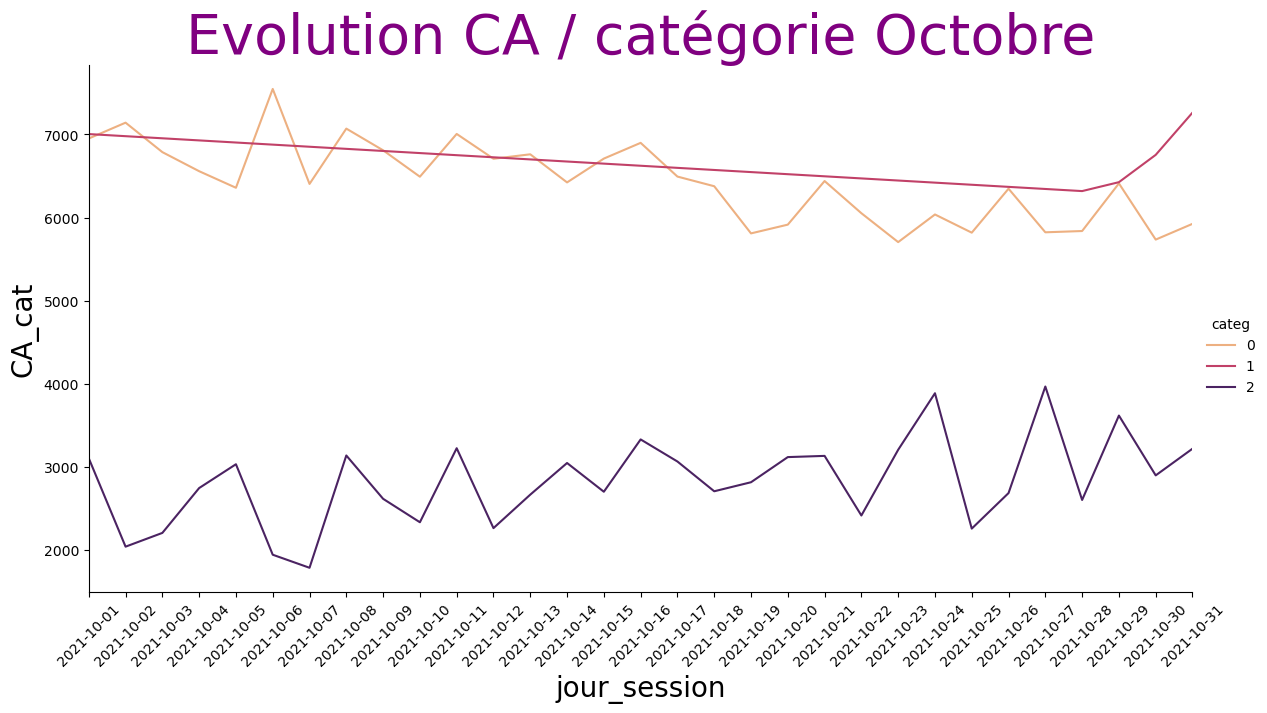

In [358]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.relplot(
    data=CA_cat_oct,
    x='jour_session', y='CA',
    hue='categ',
    kind='line',
    palette='flare',
    height=6, aspect=2
)
plt.title('Evolution CA / catégorie Octobre', fontsize=40, color='purple')
plt.xlabel('jour_session', size=20)
plt.ylabel('CA_cat', size=20)
plt.xticks(size=10, rotation=45)
plt.xlim('2021-10-01', '2021-10-31')
plt.yticks(size=10)
plt.show()

On remarque que les ventes des produits de catégorie 1 ont stagné du 1er octobre au 28 Octobre 2021

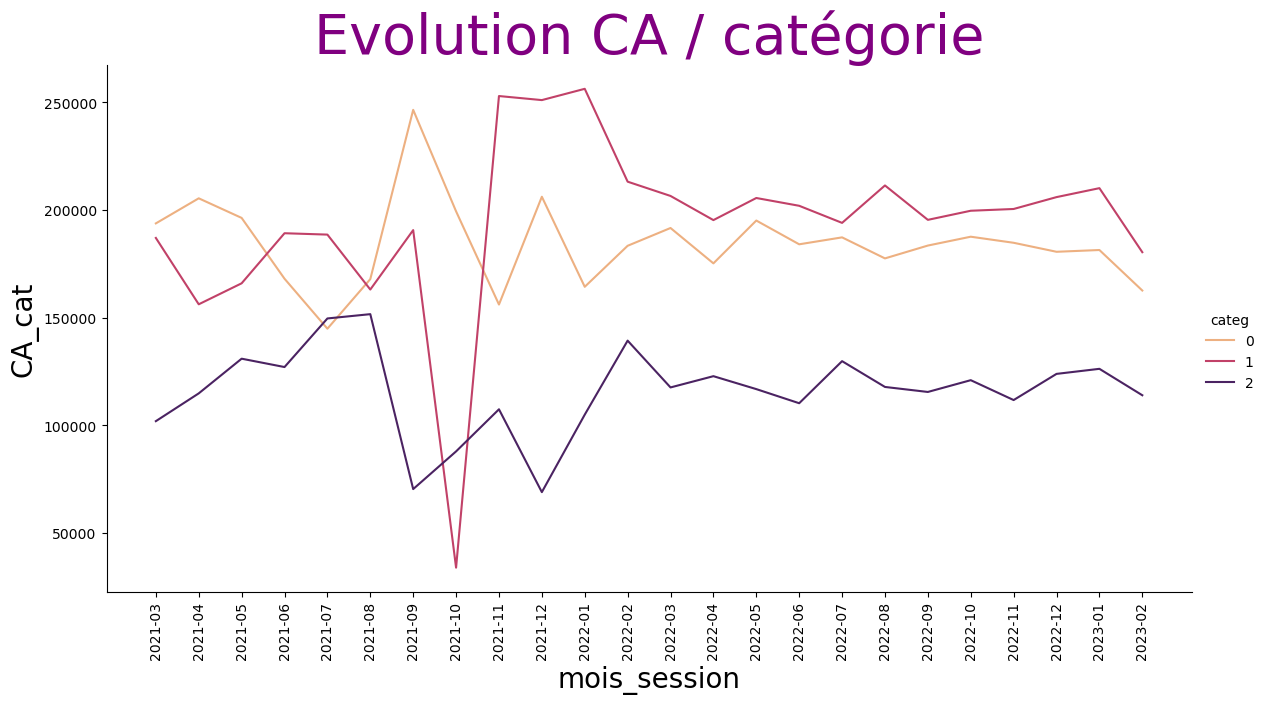

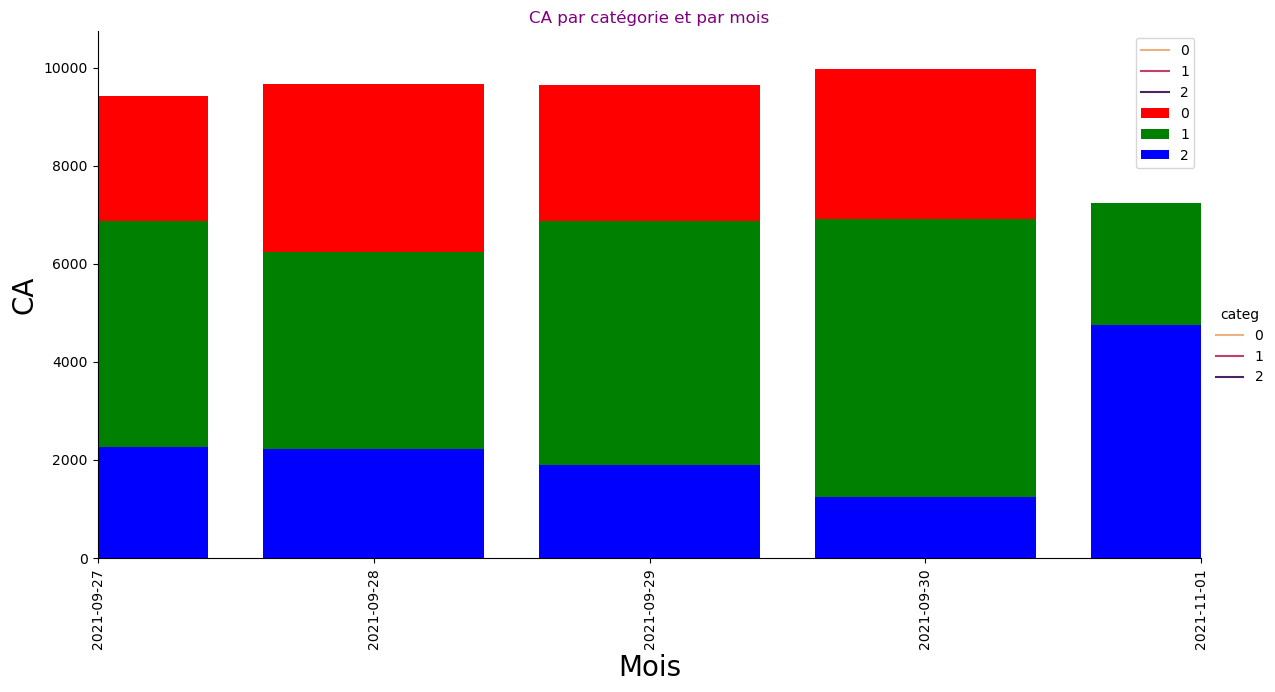

In [85]:
# The mask definition seems correct, but make sure 'day' column is a datetime object
mask = (CA_cat_jour1['jour_session'] >= '2021-01-01') & (CA_cat_jour1['jour_session'] <= '2021-12-31')
CA_jours = CA_cat_jour1.loc[mask]

# Create a barplot with different colors for each category
categories = CA_cat_jour1['categ'].unique()
colors = ['red', 'green', 'blue']  # Choose your colors

for categ, color in zip(categories, colors):
    plt.bar(CA_cat_jour1[CA_cat_jour1['categ'] == categ]['jour_session'],
            CA_cat_jour1[CA_cat_jour1['categ'] == categ]['CA'],
            color=color,
            label=categ)

# Add a title and a legend
plt.title('CA par catégorie et par mois')
plt.xlabel('Mois')
plt.ylabel('CA')
plt.xlim('2021-09-27', '2021-11-01')
plt.xticks(rotation=90)
plt.legend()

# Show the plot
plt.show()

In [86]:
# Calcul de la moyenne mobile sur une période de 3 mois
CA_mensuel['CA_moyenne_mobile'] =CA_mensuel['CA'].rolling(window=3,min_periods=1).mean()
CA_mensuel



,mois_session,CA,CA_moyenne_mobile
0,2021-03,482546.159420,482546.159420
1,2021-04,476273.487986,479409.823703
2,2021-05,493037.291706,483952.313037
3,2021-06,484170.653993,484493.811229
4,2021-07,482882.310853,486696.752184
5,2021-08,482390.339420,483147.768089
6,2021-09,507381.412560,490884.687611
7,2021-10,320880.833993,436884.195324
8,2021-11,516285.007133,448182.417895
9,2021-12,525999.373993,454388.405040


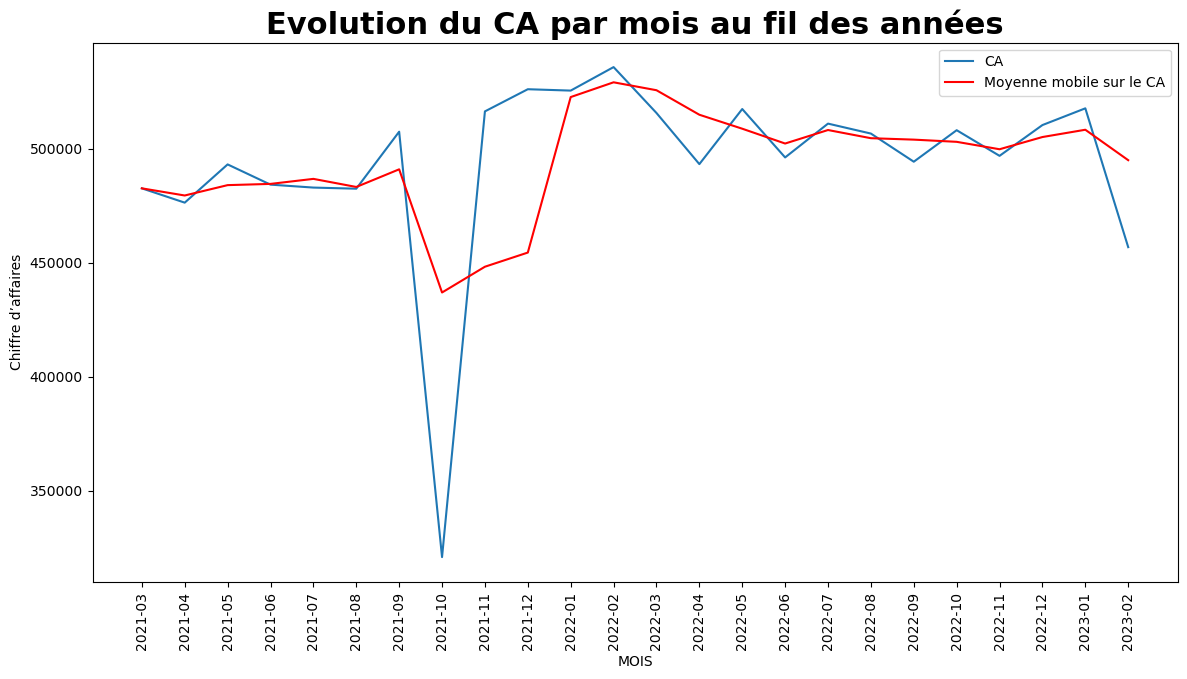

In [87]:
fig = plt.figure(figsize=(14,7))
ax = plt.axes()
plt.plot(CA_mensuel['mois_session'], CA_mensuel['CA'],label='CA')
plt.xticks(rotation=90)
plt.title("Evolution du CA par mois au fil des années", fontsize=22, fontweight='bold')
ax = ax.set(xlabel="MOIS", ylabel="Chiffre d’affaires")
plt.plot(CA_mensuel['mois_session'], CA_mensuel['CA_moyenne_mobile'],label='Moyenne mobile sur le CA', color='red')
plt.legend(loc='best')
plt.show()

Moy mobile : elle sert à stabiliser une courbe chaotique et ressortir la tendance de cette courbe tout au long de la période. voir s'il y'a un soucis. 
    

Une tendance générale de croissance modérée du chiffre d'affaires a été observée jusqu'en juin 2021, moment auquel un point d'inflexion (intersection entre la courbe du chiffre d'affaires et la moyenne mobile) indique un léger fléchissement de cette tendance jusqu'en août 2021, où elle reprend une trajectoire ascendante. La trajectoire générale du chiffre d'affaires décline de septembre 2021 à novembre 2021, mais reprend une direction positive de ce dernier mois jusqu'à mi-février 2022. Un autre déclin est noté entre février et fin avril 2022, et se répète entre fin mai et fin juin. Le chiffre d'affaires connaît une hausse durant tout le mois de juillet 2022, suivie d'une baisse entre août et septembre 2022. Il reprend une croissance en octobre 2022, qui se poursuit jusqu'en janvier 2023.

Toutefois,la diminution considérable du chiffre d'affaires est observée en Octobre 2021.

La courbe de la moyenne mobile confirme une tendance du CA à la baisse en octobre 2021.




## Zoom sur les références

In [88]:
transac_prod_final

,id_prod,date,session_id,client_id,date_day,date_month,date_year,year-month,price,categ,_merge,mois_session,semaine_session,jour_session
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,20,5,2022,2022-5,4.18,0,both,2022-05,2022-20,2022-05-20
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2,2,2022,2022-2,15.99,1,both,2022-02,2022-05,2022-02-02
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,18,6,2022,2022-6,7.99,0,both,2022-06,2022-24,2022-06-18
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,24,6,2021,2021-6,69.99,2,both,2021-06,2021-25,2021-06-24
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,11,1,2023,2023-1,4.99,0,both,2023-01,2023-02,2023-01-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,15,1,2022,2022-1,12.99,0,both,2022-01,2022-02,2022-01-15
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,19,3,2022,2022-3,10.99,1,both,2022-03,2022-11,2022-03-19
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,20,12,2022,2022-12,12.99,0,both,2022-12,2022-51,2022-12-20
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,16,7,2021,2021-7,4.98,0,both,2021-07,2021-28,2021-07-16


In [89]:
#CA par produit, agrégation sur l'id_prod et somme des prix
df_references = df_transactions.groupby(['id_prod'])['price'].sum().reset_index(name='CA')
df_references.head()

,id_prod,CA
0,0_0,4477.50
1,0_1,5154.31
2,0_10,323.10
3,0_100,61.80
4,0_1000,2790.72


In [90]:
#ajout du prix unitaire et catégorie par fusion
df_references_complet = pd.merge(df_references,produits, on='id_prod', how='left' )
#calcul de la qté vendue
df_references_complet['qté']= df_references_complet['CA']//df_references_complet['price']
df_references_complet.head()

,id_prod,CA,price,categ,qté
0,0_0,4477.50,3.75,0.0,1194.0
1,0_1,5154.31,10.99,0.0,469.0
2,0_10,323.10,17.95,0.0,17.0
3,0_100,61.80,20.60,0.0,3.0
4,0_1000,2790.72,6.84,0.0,407.0


### Les TOPS

In [91]:
#liste des 10 produits les plus vendus en qté
print('les 10 produits tops en quantité vendue sont:')
df_references_complet.sort_values('qté', ascending = False).head(10)

les 10 produits tops en quantité vendue sont:


,id_prod,CA,price,categ,qté
2590,1_369,53665.63,23.99,1.0,2237.0
2643,1_417,45611.27,20.99,1.0,2173.0
2640,1_414,51615.78,23.83,1.0,2166.0
2732,1_498,49474.29,23.37,1.0,2116.0
2652,1_425,35407.16,16.99,1.0,2083.0
2628,1_403,35080.50,17.99,1.0,1950.0
2638,1_412,32267.70,16.65,1.0,1937.0
2631,1_406,47908.11,24.81,1.0,1931.0
2639,1_413,34738.69,17.99,1.0,1930.0
2632,1_407,30748.77,15.99,1.0,1923.0


les 5 premiers dépasent le seuil de 2000 ventes

In [92]:
#liste des 10 produits qui réalisent les plus gros CA
print('les 10 produits tops en CA réalisé sont:')
df_references_complet.sort_values('CA', ascending=False).head(10)

les 10 produits tops en CA réalisé sont:


,id_prod,CA,price,categ,qté
3095,2_159,92265.68,145.99,2.0,632.0
3069,2_135,67403.23,68.99,2.0,977.0
3044,2_112,62840.10,67.57,2.0,929.0
3033,2_102,58962.58,59.14,2.0,997.0
3151,2_209,55362.09,69.99,2.0,791.0
2618,1_395,53950.39,28.99,1.0,1861.0
2590,1_369,53665.63,23.99,1.0,2237.0
3042,2_110,51916.50,62.25,2.0,834.0
2640,1_414,51615.78,23.83,1.0,2166.0
3200,2_39,51147.18,57.99,2.0,881.0


==> Top 3 avec CA réalisé supérieur à 600K€.

On note 2 références communes entre les 2 tableaux: 1_369 et 1_414.

### Les FLOPS


In [93]:
#liste des 10 produits les moins vendus en qté
print('les 10 produits tops en quantité vendue sont:')
df_references_complet.sort_values('qté', ascending = True).head(10)

les 10 produits tops en quantité vendue sont:


,id_prod,CA,price,categ,qté
313,0_1284,1.38,1.38,0.0,1.0
3174,2_23,115.99,115.99,2.0,1.0
588,0_1533,27.99,27.99,0.0,1.0
594,0_1539,0.99,0.99,0.0,1.0
2078,0_807,1.99,1.99,0.0,1.0
2107,0_833,2.99,2.99,0.0,1.0
801,0_1728,2.27,2.27,0.0,1.0
656,0_1595,2.99,2.99,0.0,1.0
2165,0_886,21.82,21.82,0.0,1.0
2178,0_898,1.27,1.27,0.0,1.0


In [94]:
#liste des 10 produits qui réalisent les moins gros CA
print('les 10 produits flops en CA réalisé sont:')
df_references_complet.sort_values('CA', ascending=True).head(10)

les 10 produits flops en CA réalisé sont:


,id_prod,CA,price,categ,qté
594,0_1539,0.99,0.99,0.0,1.0
2178,0_898,1.27,1.27,0.0,1.0
313,0_1284,1.38,1.38,0.0,1.0
1896,0_643,1.98,0.99,0.0,2.0
718,0_1653,1.98,0.99,0.0,2.0
2078,0_807,1.99,1.99,0.0,1.0
1783,0_541,1.99,1.99,0.0,1.0
664,0_1601,1.99,1.99,0.0,1.0
801,0_1728,2.27,2.27,0.0,1.0
1543,0_324,2.36,1.18,0.0,2.0


==> CA en effet très faible, surtout si on compare au CA réalisé par les Tops.



In [95]:
#nb de produits vendus qui font moins de 5€ de CA
nb_prod_flopCA = df_references_complet.loc[df_references_complet['CA']<5].shape[0]
prop_flopCA = round(nb_prod_flopCA/df_references_complet.shape[0]*100,2)
print('il y a', nb_prod_flopCA,'produits qui ont réalisé moins de 5€ de CA en 2 ans')
print('soit', prop_flopCA,'% des produits')

il y a 34 produits qui ont réalisé moins de 5€ de CA en 2 ans
soit 1.04 % des produits


In [96]:
#nb de produits vendus qu'une fois en 2 ans
nb_prod_flop = df_references_complet.loc[df_references_complet['qté']==1].shape[0]
prop_flop = round(nb_prod_flop/df_references_complet.shape[0]*100,2)
print('il y a', nb_prod_flop,'produits qui ont été vendus qu\'une fois')
print('soit', prop_flop,'% des produits')

il y a 20 produits qui ont été vendus qu'une fois
soit 0.61 % des produits


On peut s'interroger sur le fait de maintenir ces articles...



### Repartition des prix de produits par catégorie

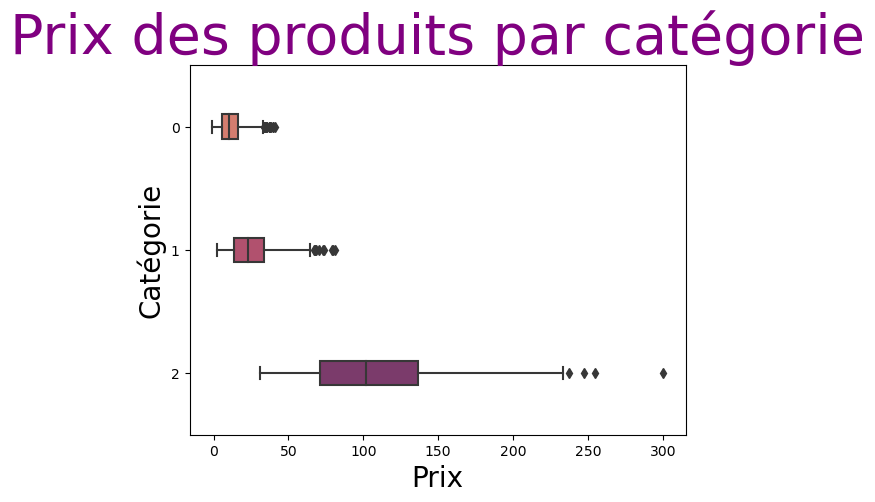

In [359]:
sns.boxplot(data=produits, x='price', y='categ', orient='h', palette='flare', width=.2)
plt.title('Prix des produits par catégorie', fontsize=40, color='purple')
plt.xlabel('Prix', size = 20)
plt.ylabel('Catégorie', size = 20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()

### La répartition des ventes par catégorie


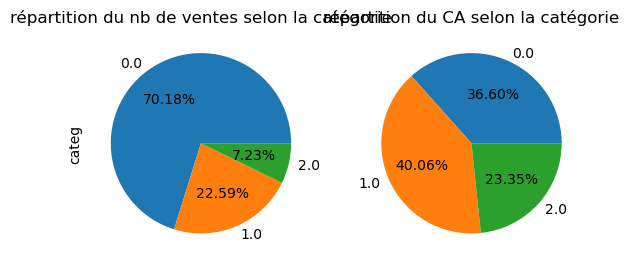

,categ,CA,CA_moyen
0,0.0,4220480.14,1843.004428
1,1.0,4619960.37,6268.602944
2,2.0,2692489.43,11408.853517


In [98]:
plt.figure(1,figsize=(10,12)) #création de la fenêtre graphique
#Graphe 1 - répartition des ventes en qté selon leur catégorie
plt.subplot(1,2,1) # division de la fenêtre avec plt.subplot(nombre de lignes, nombre de colonnes, index)
df_references_complet['categ'].value_counts(normalize=True).plot(kind='pie',autopct='%.2f%%')
plt.title('répartition du nb de ventes selon la catégorie')

#Graphe 2 - répartition des ventes en CA selon leur catégorie
plt.subplot(1,2,2)#1 ligne, 2 colonnes, 2eme position
df_references_complet['CA_bis'] = df_references_complet['CA']
CA_categ = df_references_complet.groupby(['categ']).agg({'CA':'sum','CA_bis':'mean'}).reset_index()
CA_categ.rename(columns={'CA_bis': 'CA_moyen'}, inplace=True)
plt.pie(x= CA_categ['CA'], labels = CA_categ['categ'], autopct='%.2f%%')
plt.title('répartition du CA selon la catégorie')

plt.show()

CA_categ

On constate une majorité de vente de catégorie 0 en nb et une répartition bien plus équilibrée des 3 catégories en CA.

Le tableau affiche par catégorie le CA total réalisé sur les 2 ans, et le CA moyen par produit par catégorie. ==> on constate la catégorie a un CA produit moyen bien supérieur aux 2 autres. En effet, les articles de catégorie 2 ont des prix unitaires bien plus élevés.

## Les profils de nos clients

Répartition par genre,
Répartition par tranche d'âge
Répartition du CA via une Courbe de Lorenz

In [99]:
#création d'un df des transactions par client
transac_client = df_transactions.groupby(['client_id'])['price'].sum().reset_index(name='CA')
transac_client.head()

,client_id,CA
0,c_1,550.19
1,c_10,1353.60
2,c_100,254.85
3,c_1000,2209.92
4,c_1001,1720.08


In [100]:
print('il y a',transac_client.shape[0],'clients qui ont effectués des transactions sur la période')
print('et il y a', clients.shape[0], 'dans notre fichier clients')

il y a 8598 clients qui ont effectués des transactions sur la période
et il y a 8623 dans notre fichier clients


Les répartitions se feront sur tous les clients qu'ils aient ou non effectué des transactions.



In [101]:
#création d'un df qui fusionne les données clients et CA en externe pour conserver toutes les données
transac_client_complet = pd.merge(transac_client, clients, on='client_id', how = 'outer')

In [102]:
transac_client_complet.shape[0]


8623

==> Nous avons bien conservé tous les clients même ceux qui n'ont pas effectué de transaction. On va remplacer les nan de CA par des zéros.



In [103]:
#remplace les nan par 0
transac_client_complet.loc[transac_client_complet['CA'].isna(), 'CA']= 0

### Répartition par genre


In [104]:
#répartition homme-femme en nb
# regroupement par sex et compte des clients
df_genre_nb = transac_client_complet.groupby(['sex'])['client_id'].count().reset_index(name='nb')
df_genre_nb.head()

,sex,nb
0,f,4491
1,m,4132


In [105]:
#répartition homme-femme en CA
#regroupement par sex et somme des CA
df_genre_CA = transac_client_complet.groupby(['sex'])['CA'].agg(['sum','mean','std'])
df_genre_CA = df_genre_CA.reset_index()

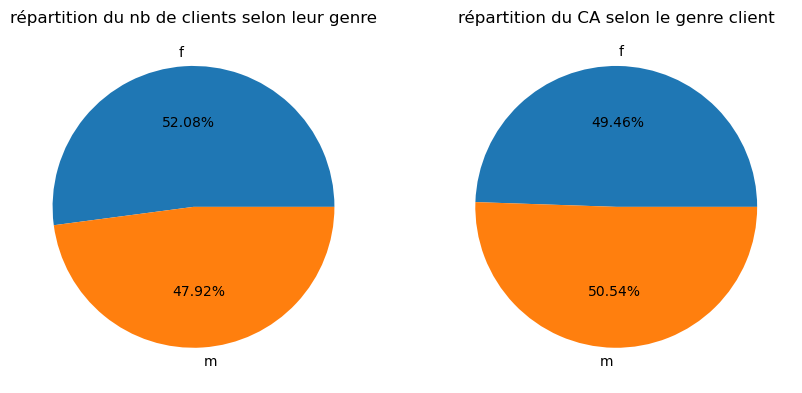

In [106]:
#Graphes répartition du nb et du CA selon genre
plt.figure(1,figsize=(10,12)) #création de la fenêtre graphique
#Graphe 1 - répartition du nb
plt.subplot(1,2,1) # division de la fenêtre avec plt.subplot(nombre de lignes, nombre de colonnes, index), 1 ligne, 2 colonnes, position 1
plt.pie(x= df_genre_nb['nb'], labels = df_genre_nb['sex'], autopct='%.2f%%')
plt.title('répartition du nb de clients selon leur genre')
#Graphe 2 - répartition du CA
plt.subplot(1,2,2)#1 ligne, 2 colonnes, 2eme position
plt.pie(x= df_genre_CA['sum'], labels = df_genre_CA['sex'], autopct='%.2f%%')
plt.title('répartition du CA selon le genre client')

plt.show()

La répartition selon le genre en nb et en CA est très équilibrée. Les femmes sont plus nbreuses mais réalisent un peu moins de CA.



In [107]:
#Regardons le CA moyen et l'écart-type par genre:

df_genre_CA.head()


,sex,sum,mean,std
0,f,5.705708e+06,1270.476100,2403.483776
1,m,5.829732e+06,1410.874034,6816.930301


Vérifions l'intervalle de confiance de la moyenne.



In [108]:
import scipy, math
alpha = 0.05 #test 5%
xbar= transac_client_complet['CA'].mean()
n = len(transac_client_complet) #longueur échantillon
sprime = transac_client_complet['CA'].std()
icinf=xbar-scipy.stats.t.ppf(1-alpha/2,n-1)*sprime/math.sqrt(n)
icsup=xbar+scipy.stats.t.ppf(1-alpha/2,n-1)*sprime/math.sqrt(n)
print('l\'intervalle de confiance de la moyenne est donc [',round(icinf,2),',',round(icsup,2),']')

l'intervalle de confiance de la moyenne est donc [ 1231.62 , 1443.89 ]


Le CA moyen pour un homme est dans l'intervalle de confiance, idem pour les femmes.

==> le genre n'est pas un critère d'analyse pour le CA moyen et le nb de vente.

### Répartition par tranche d'âge


In [109]:
#faire juste un count
age_counts = clients['Âge'].value_counts().sort_index()
age_counts.head(20)

19    440
20    146
21    146
22    129
23    136
24    160
25    138
26    152
27    179
28    175
29    156
30    137
31    188
32    145
33    148
34    148
35    207
36    176
37    203
38    115
Name: Âge, dtype: int64

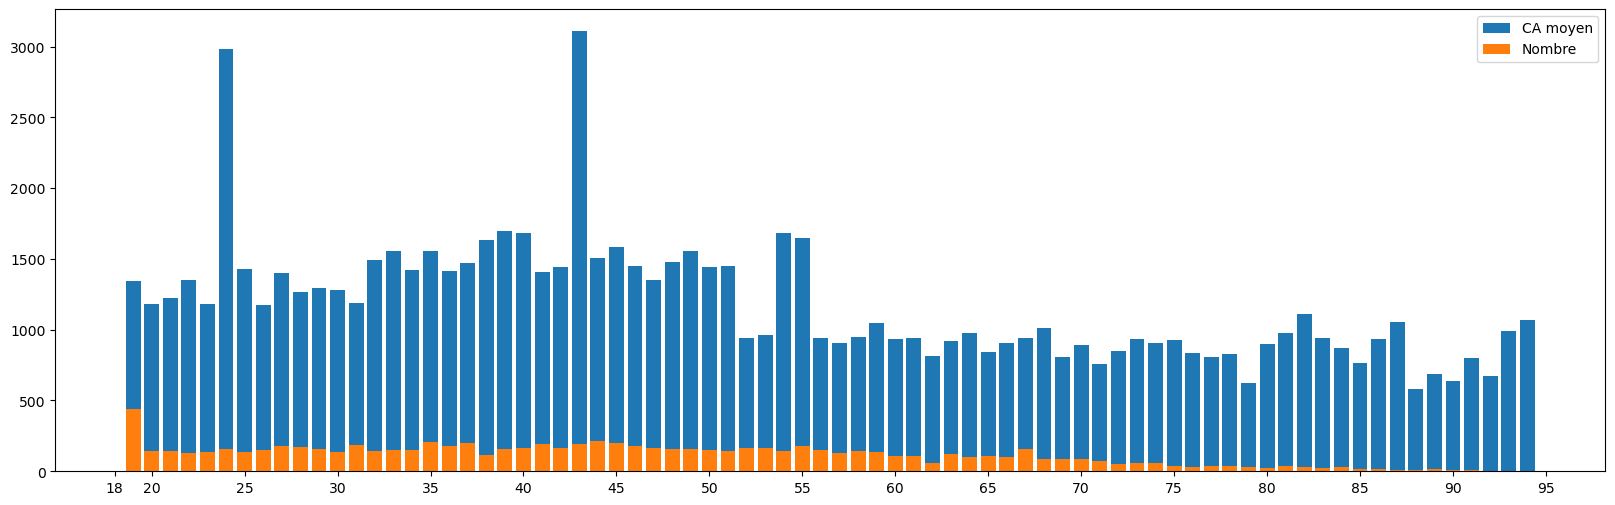

In [110]:
df_age = transac_client_complet.groupby(['Âge']).agg({'CA':'mean', 'client_id':'count'})
df_age = df_age.reset_index()
df_age.rename(columns={'client_id': 'Nb'}, inplace=True)
df_age.rename(columns={'CA': 'CA_moyen'}, inplace=True)
#graphe de répartition selon age du CA moyen et du nb
plt.figure(figsize=(20,6))
plt.bar(df_age['Âge'], df_age['CA_moyen'], label ='CA moyen')
plt.bar(df_age['Âge'], df_age['Nb'], label ='Nombre')
plt.xticks([18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95 ])
plt.legend()
plt.show()

Nb: l'âge 19 ans (18 ans en 2022) a un effectif de plus du double des autres, suspect!

en CA moyen: 23 et 42 sortent du lot; et 53 et 54 idem pour leur tranche.

les tranches retenues: 18-24; 25-34; 35-44; 45-54; 55-64; 65-74; 75 et +.

In [111]:
#nb de clients de 19ans? 
nb_19 = transac_client_complet.loc[transac_client_complet['Âge']==19].shape[0]
nb_19_0CA = transac_client_complet.loc[(transac_client_complet['Âge']==19)&(transac_client_complet['CA']==0)].shape[0]
print(nb_19,'clients de 19 ans dont',nb_19_0CA,'sans achat')

440 clients de 19 ans dont 3 sans achat


Hypothèse: clients de moins de 18 ans qui ont saisi une date de naissance erronée pour créer leur fiche.



In [112]:
#création d'une nouvelle colonne tranche_age
transac_client_complet['tranche_age'] = '18-24'
transac_client_complet['tranche_age'].loc[(transac_client_complet['Âge']>24)&(transac_client_complet['Âge']<35)] = '25-34'
transac_client_complet['tranche_age'].loc[(transac_client_complet['Âge']>34)&(transac_client_complet['Âge']<45)] = '35-44'
transac_client_complet['tranche_age'].loc[(transac_client_complet['Âge']>44)&(transac_client_complet['Âge']<55)] = '45-54'
transac_client_complet['tranche_age'].loc[(transac_client_complet['Âge']>54)&(transac_client_complet['Âge']<65)] = '55-64'
transac_client_complet['tranche_age'].loc[(transac_client_complet['Âge']>64)&(transac_client_complet['Âge']<75)] = '65-74'
transac_client_complet['tranche_age'].loc[(transac_client_complet['Âge']>75)] = '75+'

In [113]:
#calcul du CA moyen et du nb de clients par tranche d'age
df_tranche = transac_client_complet.groupby(['tranche_age']).agg({'CA':'mean', 'client_id':'count'})
df_tranche = df_tranche.reset_index()
df_tranche.rename(columns={'client_id': 'Nb'}, inplace=True)
df_tranche.rename(columns={'CA': 'CA_moyen'}, inplace=True)

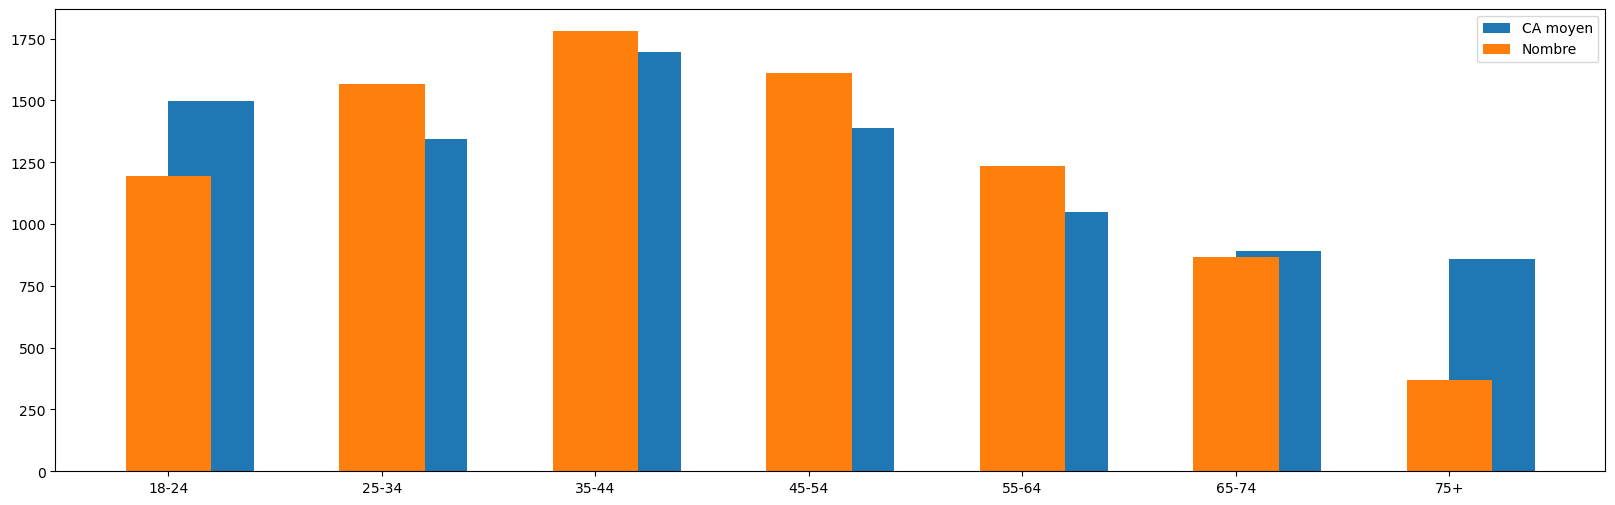

In [114]:
#graphe de répartition selon age du CA moyen et du nb
plt.figure(figsize=(20,6))
plt.bar(df_tranche['tranche_age'], df_tranche['CA_moyen'], label ='CA moyen', align='edge', width=0.4)
plt.bar(df_tranche['tranche_age'], df_tranche['Nb'], label ='Nombre', width=0.4)
#plt.plot(df_tranche['tranche_age'], df_tranche ['std'], label='Ecart-type', color='black')
plt.legend()
plt.show()

la tranche 35-44 est la plus nombreuse et celle qui réalise le plus de CA.
la tranche 75 et + est la moins nombreuse et réalise pourtant un important CA.

### Répartition du CA: courbe de Lorenz

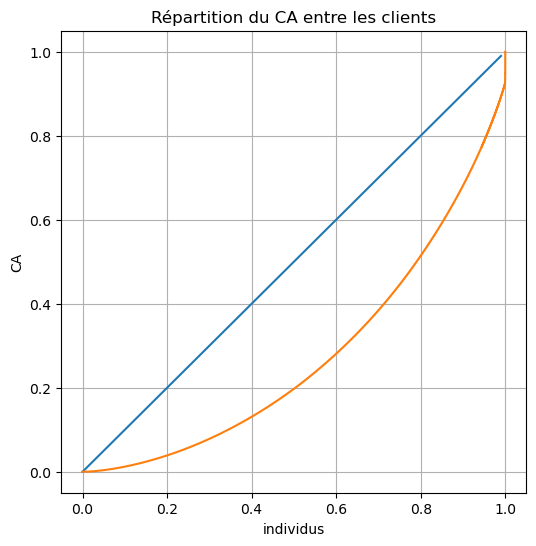

l'indice de Gini est  0.44900947282921044


In [115]:
#construction de la courbe de Lorenz
CA_client = transac_client_complet['CA'].values #les valeurs de CA
n = len(CA_client)
lorenz = np.cumsum(np.sort(CA_client)) / CA_client.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
plt.figure(figsize=(6,6))
xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.

# Diagonale
a = np.arange(0,1,.01)
x = a
y = a
    
# Graphique
sns.lineplot(x=x,y=y)
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.grid()
plt.xlabel('individus')
plt.ylabel('CA')
plt.title('Répartition du CA entre les clients')
plt.show()

#calcul de l'indice de Gini
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
print ('l\'indice de Gini est ', gini)

Sert à regarder la relation entre 2 variables. pour voir s'il existe un effet Pareto ou pas.



On constate une inégalité de repartition du CA entre tous les clients,

la courbe finit à la vertical ==> doit avoir de gros clients
50% du CA est fait par 80% des clients
==> confirmé par le calcul de l'indice de GINI. Celui-ci est compris entre 0 et 1, 0 étant égalitaire et 1 pas du tout

In [116]:
#liste des GROS clients
transac_client_complet.sort_values('CA',ascending=False).head(5)

,client_id,CA,sex,birth,Âge,tranche_age
677,c_1609,312755.08000,m,1980,43,35-44
4387,c_4958,282654.61000,m,1999,24,18-24
6336,c_6714,149854.11628,f,1968,55,55-64
2723,c_3454,111801.89314,m,1969,54,45-54
2108,c_2899,5214.05000,f,1994,29,25-34


On voit les 4 gros clients qui sortent du lot par rapport au 5ème. On avait en effet identifié dans le diagramme des ages que les 4 ages 42, 23, 54, 53 généraient les plus importants CA.



In [117]:
#calcul du CA réalisé par ces 4 gros clients
clients_pro=['c_1609', 'c_4958','c_6714','c_3454']
transac_pro = transac_client_complet.loc[transac_client_complet['client_id'].isin(clients_pro)]
CA_pro=transac_pro['CA'].sum()
CA_Total=transac_client_complet['CA'].sum()
print('Le CA réalisé par les 4 gros clients est de', round(CA_pro,2),'€, soit', round(CA_pro*100/CA_Total,2),'% du CA total.')

Le CA réalisé par les 4 gros clients est de 857065.7 €, soit 7.43 % du CA total.


On peut émettre l'hypothèse que ces 4 gros clients sont des clients professionnels.


ERRATUM: ces 4 clients sont des outliers, je devrais les exclure de mon analyse pour la partie 4.

In [118]:
transac_client_part = transac_client_complet.loc[transac_client_complet['client_id'].isin(clients_pro)]


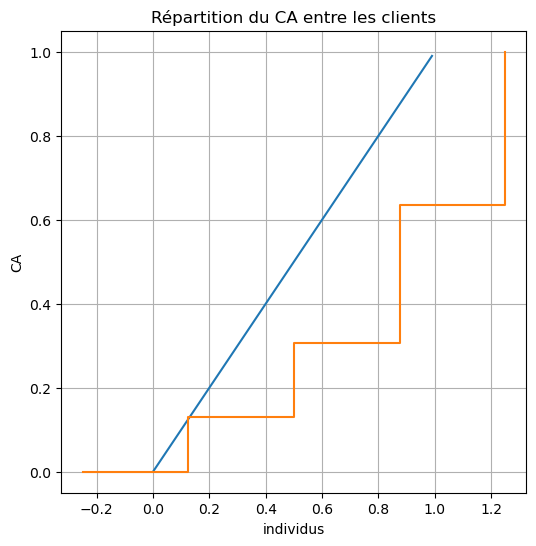

l'indice de Gini est  0.21458683237431364


In [355]:
#construction de la courbe de Lorenz sans les gros clients
CA_client = transac_client_part['CA'].values #les valeurs de CA
n = len(CA_client)
lorenz = np.cumsum(np.sort(CA_client)) / CA_client.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
plt.figure(figsize=(6,6))
xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.

# Diagonale
a = np.arange(0,1,.01)
x = a
y = a
    
# Graphique
sns.lineplot(x=x,y=y)
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.grid()
plt.xlabel('individus')
plt.ylabel('CA')
plt.title('Répartition du CA entre les clients')
plt.show()

#calcul de l'indice de Gini
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
print ('l\'indice de Gini est ', gini)

## Analyse des comportements clients

Pour l'ensemble des calculs qui vont être effectué ici, nous allons chercher à démontrer que les valeurs observées sont significatives : pour cela nous allons comparer notre p-valeur avec un seuil alpha de 5%. 

Nos hypothèses sont les suivants :

**H0:Absence de corrélation entre les deux variables.**

**H1:Présence d'une corrélation entre les deux variables.**

Si le résultat de la p-valeur obtenue pour chaque analyse est inférieur à notre seuil alpha(5%), nous allons rejeter notre hypothèse nulle (H0 = absence de corrélation:les deux variables sont indépendantes) et nous allons considérer notre hypothèse (H1=présence d'une relation: les deux variables sont dépendantes).

In [119]:
# construction d'un df complet à partir des df_transactions et clients
df_complet = pd.merge(df_transactions, clients, on='client_id', how='left' )
df_complet.shape

(657726, 17)

In [120]:
df_transactions

,id_prod,date,session_id,client_id,date_day,date_month,date_year,year-month,price,categ,_merge,mois_session,semaine_session,jour_session
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,20,5,2022,2022-5,4.18,0,both,2022-05,2022-20,2022-05-20
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2,2,2022,2022-2,15.99,1,both,2022-02,2022-05,2022-02-02
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,18,6,2022,2022-6,7.99,0,both,2022-06,2022-24,2022-06-18
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,24,6,2021,2021-6,69.99,2,both,2021-06,2021-25,2021-06-24
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,11,1,2023,2023-1,4.99,0,both,2023-01,2023-02,2023-01-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,15,1,2022,2022-1,12.99,0,both,2022-01,2022-02,2022-01-15
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,19,3,2022,2022-3,10.99,1,both,2022-03,2022-11,2022-03-19
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,20,12,2022,2022-12,12.99,0,both,2022-12,2022-51,2022-12-20
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,16,7,2021,2021-7,4.98,0,both,2021-07,2021-28,2021-07-16


### lien entre le genre d’un client et les catégories des livres achetés


Les deux variables sont qualitatives et proviennent de deux echantillons indépendants.\
Nous allons réaliser un heatmap sur un tableau de contingence et un tgest statistique d'association sur deux variables qualitatives provenant de deux échantillons indépendants.\ 
H0 : La variable genre et la variable catégorie des produits achetés sont indépendants\
H1 : Les deux variables dont dépendantes

In [121]:
#pour chaque genre, par catégorie (colonnes), calcul du nbre de produits
table_genre_categ=df_complet.pivot_table(index='sex', columns='categ', values ='id_prod', aggfunc='count',margins=True, margins_name='Total')
#table_genre_categ = table_genre_categ.reset_index()
table_genre_categ.head()

categ,0,1,2,Total
sex,,,,
f,197098,114087,16722,327907
m,199813,111416,18590,329819
Total,396911,225503,35312,657726


Le tableau de contingence se calcule grâce à la méthode  pivot_table. Chaque case du tableau de contingence compte un nombre d'individus et ce comptage se fait grâce à la fonction len.

In [122]:
import matplotlib.pyplot as plt


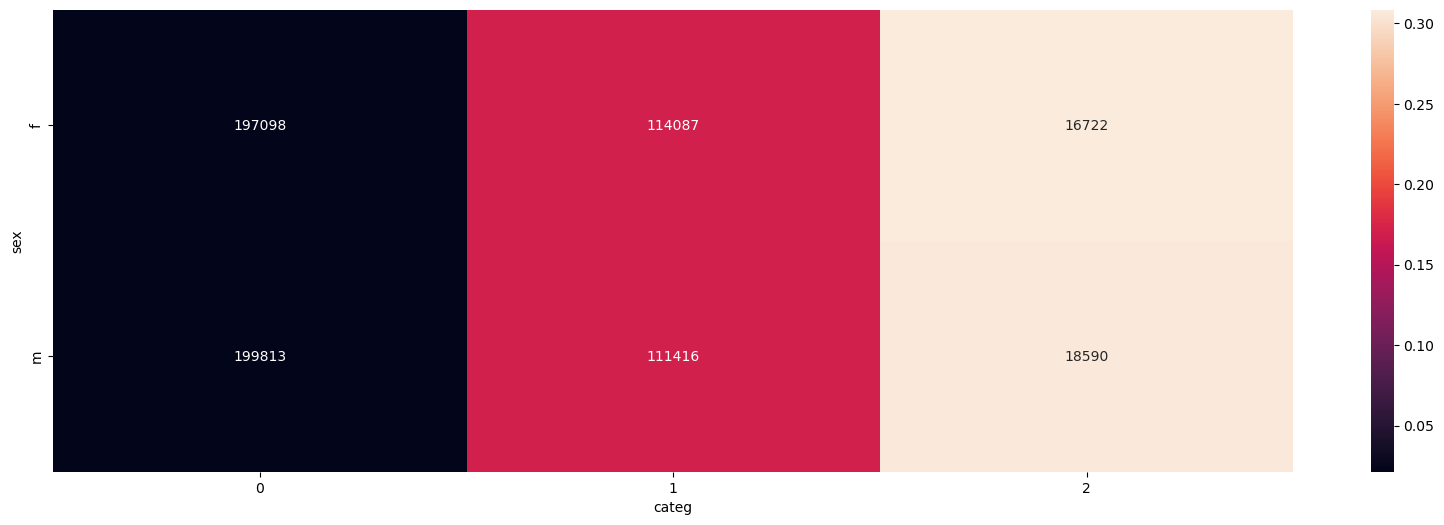

In [123]:
#Affichage du tableau de contingence en heatmap.


tx = table_genre_categ.loc[:,["Total"]]
ty = table_genre_categ.loc[["Total"],:]
n = len(df_complet)
indep = tx.dot(ty) / n
c = table_genre_categ.fillna(0) #On remplace les valeurs nulles par 0

measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = (measure/xi_n)
plt.figure(figsize=(20,6))
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1], fmt=".0f")
plt.show()

In [124]:
#calcul des proportions

==> D'après les codes couleurs, les catégories de livres achetés semblent ne pas avoir de corrélation avec le genre de l'acheteur. D'après le nb d'occurences, la categ2 semble être dépendante du genre.

#calcul du degré de liberté

Le tableau de contingence contient (2lignes-1) * (3colonnes-1) = **2 degrés de liberté.** \
Dans la table de loi du Khi2, pour une p-valeur de 0.05, on obtient une **valeur critique de 5.99**.

In [125]:
xi_n = measure.sum().sum()
xi_n


143.4684942757229

Nous savons que plus ξn(xi_n)est grand, moins l'hypothèse d'indépendance est valide.

La valeur du xi_n=143.4684942757229 qui semble plutôt grand et supérieur à notre valeur critique(5.99), nous permet d'invalider l'hypothèse d'indépendance et nous amène à conclure à une dépendance entre le genre et la catégorie des produits achetés.

Toutefois, nous allons effectuer le test ce chi2 pour confirmer ou infirmer cette information.

In [126]:
#calcul du Chi2: déjà calculé dans le code du heatmap xi_n
print('le Chi2 calculé est de ', xi_n)

le Chi2 calculé est de  143.4684942757229


In [127]:
from scipy.stats import chi2_contingency


In [128]:
#Effectuons le test du Chi carré(test d'indépendance)
chi2, p, dof, expected = chi2_contingency(table_genre_categ)

print(f"Chi-square Statistic : {chi2}")
print(f"P-value : {p}")

Chi-square Statistic : 143.4684942757229
P-value : 1.8567023620869968e-28


La p-value étant de 1.856e-28 donc inférieur à 0,05. 
L'hypothèse nulle est rejetée. ==> le genre de l'acheteur et la catégorie de livres achetés ne sont pas indépendants.



### Lien entre âge et montant total des achats


Nous avons deux variables quantitatives.
Nous réaliserons un nuage de points comme visualisation et un test d'association entre deux variables quantitatives comme test statistique.

In [129]:
transac_client_complet

,client_id,CA,sex,birth,Âge,tranche_age
0,c_1,550.19,m,1955,68,65-74
1,c_10,1353.60,m,1956,67,65-74
2,c_100,254.85,m,1992,31,25-34
3,c_1000,2209.92,f,1966,57,55-64
4,c_1001,1720.08,m,1982,41,35-44
...,...,...,...,...,...,...
8618,c_7584,0.00,f,1960,63,55-64
8619,c_90,0.00,m,2001,22,18-24
8620,c_587,0.00,m,1993,30,25-34
8621,ct_1,0.00,m,2001,22,18-24


In [130]:
transac_prod_client=pd.merge(transac_prod_final,clients,on='client_id' ,how='left')
transac_prod_client

,id_prod,date,session_id,client_id,date_day,date_month,date_year,year-month,price,categ,_merge,mois_session,semaine_session,jour_session,sex,birth,Âge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,20,5,2022,2022-5,4.18,0,both,2022-05,2022-20,2022-05-20,f,1986,37
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2,2,2022,2022-2,15.99,1,both,2022-02,2022-05,2022-02-02,m,1988,35
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,18,6,2022,2022-6,7.99,0,both,2022-06,2022-24,2022-06-18,f,1968,55
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,24,6,2021,2021-6,69.99,2,both,2021-06,2021-25,2021-06-24,m,2000,23
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,11,1,2023,2023-1,4.99,0,both,2023-01,2023-02,2023-01-11,m,1980,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,15,1,2022,2022-1,12.99,0,both,2022-01,2022-02,2022-01-15,f,1951,72
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,19,3,2022,2022-3,10.99,1,both,2022-03,2022-11,2022-03-19,f,1977,46
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,20,12,2022,2022-12,12.99,0,both,2022-12,2022-51,2022-12-20,f,1988,35
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,16,7,2021,2021-7,4.98,0,both,2021-07,2021-28,2021-07-16,m,1986,37


In [131]:
transac_prod_client_part=transac_prod_client[~transac_prod_client['client_id'].isin(clients_pro)]
transac_prod_client_part

,id_prod,date,session_id,client_id,date_day,date_month,date_year,year-month,price,categ,_merge,mois_session,semaine_session,jour_session,sex,birth,Âge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,20,5,2022,2022-5,4.18,0,both,2022-05,2022-20,2022-05-20,f,1986,37
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,2,2,2022,2022-2,15.99,1,both,2022-02,2022-05,2022-02-02,m,1988,35
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,24,6,2021,2021-6,69.99,2,both,2021-06,2021-25,2021-06-24,m,2000,23
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,11,1,2023,2023-1,4.99,0,both,2023-01,2023-02,2023-01-11,m,1980,43
5,0_1418,2022-10-20 15:59:16.084030,s_285425,c_1478,20,10,2022,2022-10,8.57,0,both,2022-10,2022-42,2022-10-20,f,1972,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,15,1,2022,2022-1,12.99,0,both,2022-01,2022-02,2022-01-15,f,1951,72
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,19,3,2022,2022-3,10.99,1,both,2022-03,2022-11,2022-03-19,f,1977,46
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,20,12,2022,2022-12,12.99,0,both,2022-12,2022-51,2022-12-20,f,1988,35
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,16,7,2021,2021-7,4.98,0,both,2021-07,2021-28,2021-07-16,m,1986,37


In [132]:
#Création d'un df avec le montant total des achats par âge

montant_par_age= transac_prod_client_part.groupby('Âge')['price'].sum().reset_index()
montant_par_age

,Âge,price
0,19,609013.690000
1,20,178195.780000
2,21,184212.533140
3,22,178497.700000
4,23,165031.435427
...,...,...
71,90,5266.077713
72,91,5043.190000
73,92,2815.450000
74,93,4013.870000


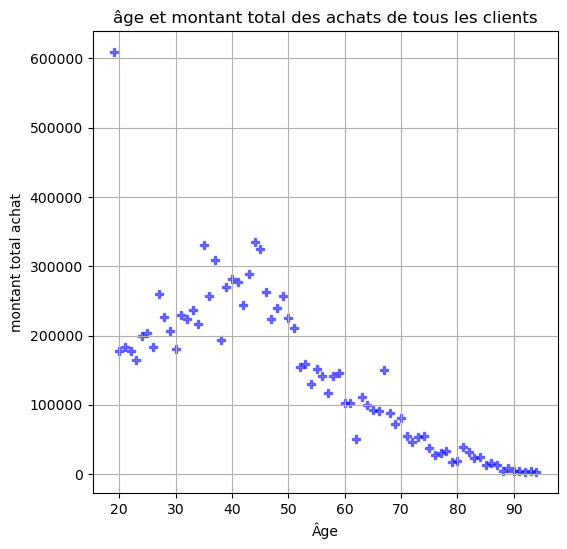

In [133]:
#Analyse de corrélation quanti / quanti: visualisation du graphe nuage de points.

plt.figure(figsize=(6,6))
plt.scatter(montant_par_age['Âge'], montant_par_age['price'], alpha=0.5, c='blue', marker='P')
plt.grid()
plt.xlabel('Âge')
plt.ylabel('montant total achat')
plt.title('âge et montant total des achats de tous les clients')
plt.show()

Nous constatons alors une corrélation entre l'âge des clients et le montant de leurs achats, avec une augmentation progressive du montant des achats à mesure que l'âge augmente pour les clients âgés de 19 à 45 ans environ. Mais au-delà de cette tranche d'âge, nous observons une diminution du montant des achats au fur et à mesure que l'âge augmente.

In [134]:
#Test de normalité de Kolmogorov-Smirnov pour l'âge
age = montant_par_age['Âge']
ks_statistic, p_value = stats.kstest(age, 'norm', args=(np.mean(age), np.std(age)))

print(f"Kolmogorov-Smirnov test pour l'âge: KS Statistic:{ks_statistic}, p-value:{p_value}")

if p_value < 0.05:
    print("La distribution ne suit pas une loi normale.")
else:
    print("La distribution suit une loi normale.")

#Test de normalité de Kolmogorov-Smirnov pour le montant des achats
price = montant_par_age['price']
ks_statistic, p_value = stats.kstest(price, 'norm', args=(np.mean(price), np.std(price)))

print(f"Kolmogorov-Smirnov test pour le montant des achats: KS Statistic:{ks_statistic}, p-value:{p_value}")

if p_value < 0.05:
    print("La distribution ne suit pas une loi normale.")
else:
    print("La distribution suit une loi normale.")

Kolmogorov-Smirnov test pour l'âge: KS Statistic:0.0638004630812204, p-value:0.8968673444312906
La distribution suit une loi normale.
Kolmogorov-Smirnov test pour le montant des achats: KS Statistic:0.11465163757790325, p-value:0.25073147123142214
La distribution suit une loi normale.


**Etant donné que les résultats précedents nous montrent que les deux variables suivent une loi normale**, nous allons utiliser un **test paramétrique** à savoir le **test de Pearson**.

In [135]:
#Calcul du coefficient de Pearson et de la covariance
age = montant_par_age["Âge"]
price = montant_par_age["price"]

print("Coefficient de Paerson:\n",st.pearsonr(age, price)[0])
print("Covariance:\n",np.cov(age, price, ddof=0)[1, 0])

Coefficient de Paerson:
 -0.8305934554423997
Covariance:
 -2042067.4527083384


In [136]:
#Calcul du coefficient de corrélation de Pearson(r)
pearsonr(montant_par_age['price'], montant_par_age['Âge'])

PearsonRResult(statistic=-0.8305934554423997, pvalue=1.699233117362084e-20)

Le coefficient de corrélation de Pearson est de -0.8310031794792778. Cela indique une corrélation négative modérée à forte entre l'âge et le montant des achats. Une valeur proche de -1 suggère une relation linéaire inverse entre les variables, ce qui signifie  le montant des achat et l'âge ont tendance à évoluer de manière opposée.En d'autre terme,lorsque l'âge augmente, le montant des achats diminue de manière prévisible.

De plus **p-value<0.05, nous allons alors rejeter notre hypothèse H0**.\
Nous pouvons conclure que **les variables âge et montant des achats sont corrélés mais négativement au vue de notre coefficient de Pearson.**

Lorsqu'il est égal à 1, il y'a corrélation. 
Lorsqu'il est égal à 0, il n'y a pas corrélation

On ne peut pas dire qu'il y'a une absence de corrélation au niveau du risque de 5 %

Quand c'est négatif, les 2 variables n'évoluent pas dans le même sens et inversement.


### lien entre l’âge des clients et la fréquence d’achat


Nous avons deux variables quantitatives. 

Nous allons réaliser un nuage de points pour la visualisation.

In [142]:
#Nbre de session totale par âge

#Nbre de session totale pour toute la BD
#frq d'achat = Nbre de session par âge/Nbre de session totale

In [143]:
# Trouver le nombre de sessions par âge
sessions_par_age = df_complet.groupby('Âge')['Âge'].count().reset_index(name='Nombre de sessions')

# Affichage du résultat
sessions_par_age

,Âge,Nombre de sessions
0,19,14769
1,20,4238
2,21,4468
3,22,4161
4,23,4299
...,...,...
71,90,315
72,91,293
73,92,164
74,93,222


In [144]:
# Calcul du nombre total de sessions
nombre_total_sessions = df_complet['session_id'].count()

# Affichage du résultat
print("Le nombre total de sessions est de :", nombre_total_sessions)

Le nombre total de sessions est de : 657726


In [145]:
#Création de la variable fréq (fréquence d'achat sur la période étudiée)
#frq d'achat = Nbre de session par âge/Nbre de session totale
sessions_par_age['freq'] = sessions_par_age['Nombre de sessions'] / nombre_total_sessions
sessions_par_age

,Âge,Nombre de sessions,freq
0,19,14769,0.022455
1,20,4238,0.006443
2,21,4468,0.006793
3,22,4161,0.006326
4,23,4299,0.006536
...,...,...,...
71,90,315,0.000479
72,91,293,0.000445
73,92,164,0.000249
74,93,222,0.000338


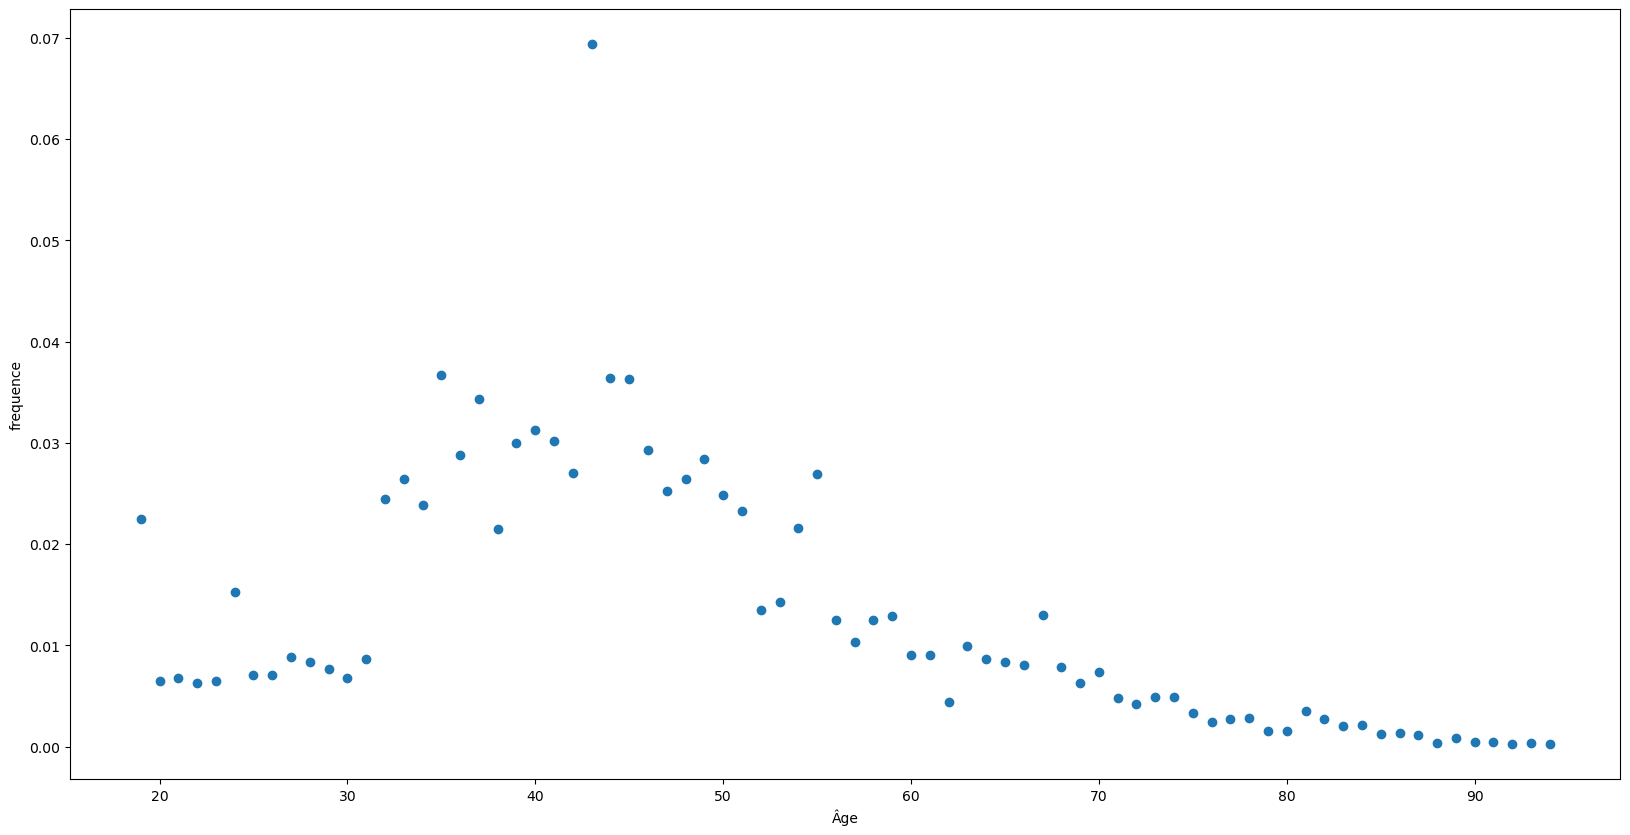

In [146]:
#Graphique de dispersion pour visualiser la relation entre l'âge et la fréquence d'achat
plt.figure(figsize = (20, 10))
plt.plot(sessions_par_age['Âge'], sessions_par_age['freq'], "o")
plt.xlabel("Âge")
plt.ylabel("frequence")
plt.show()

A première vue, nous pouvons dire qu'il y'a pas de relation linéaire en l'âge et la fréquence d'achat. 


In [147]:
import statsmodels.api as sm

In [148]:
#Régression linéaire
Y =sessions_par_age['freq']
X = sessions_par_age[['Âge']]
X = X.copy()  
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()  
a,b = result.params['Âge'],result.params['intercept']

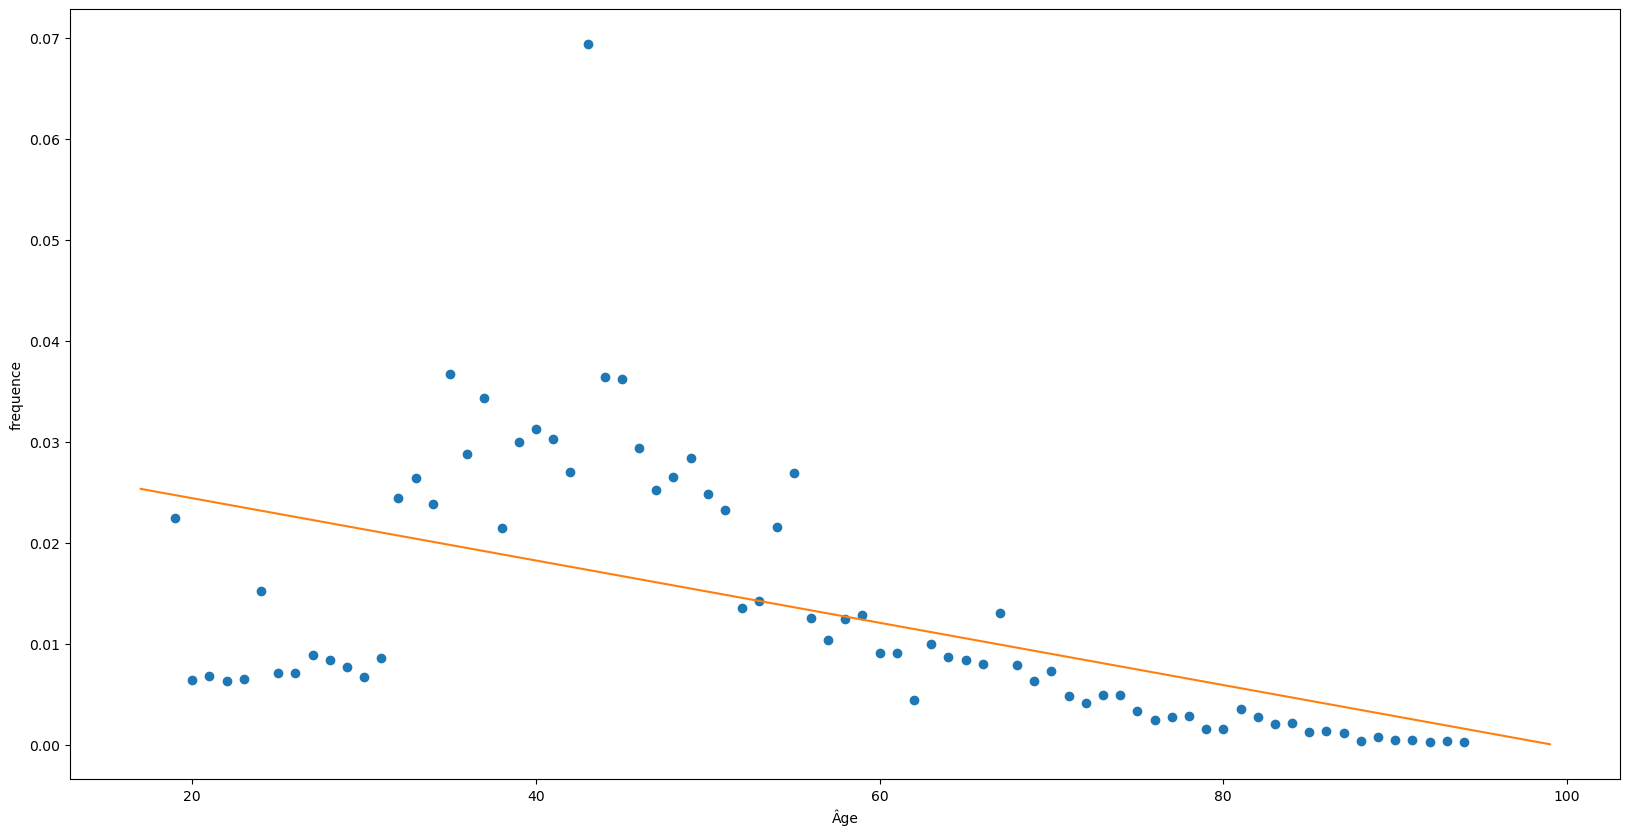

In [149]:
plt.figure(figsize = (20, 10))
plt.plot(sessions_par_age['Âge'], sessions_par_age['freq'], "o")
plt.plot(np.arange(17,100),[a*x+b for x in np.arange(17,100)])
plt.xlabel("Âge")
plt.ylabel("frequence")
plt.show()

Après la regression linéaire, observer la normalité des résidus. 

In [150]:
#Test de normalité de Kolmogorov-Smirnov pour l'âge
age = sessions_par_age['Âge']
ks_statistic, p_value = stats.kstest(age, 'norm', args=(np.mean(age), np.std(age)))

print(f"Kolmogorov-Smirnov test pour l'âge: KS Statistic:{ks_statistic}, p-value:{p_value}")

if p_value < 0.05:
    print("La distribution ne suit pas une loi normale.")
else:
    print("La distribution suit une loi normale.")


#Test de normalité de Kolmogorov-Smirnov pour la fréquence d'achats
freq = sessions_par_age['freq']
ks_statistic, p_value = stats.kstest(freq, 'norm', args=(np.mean(freq), np.std(freq)))

print(f"Kolmogorov-Smirnov test pour la fréquence d'achats: KS Statistic:{ks_statistic}, p-value:{p_value}")

if p_value < 0.05:
    print("La distribution ne suit pas une loi normale.")
else:
    print("La distribution suit une loi normale.")

Kolmogorov-Smirnov test pour l'âge: KS Statistic:0.0638004630812204, p-value:0.8968673444312906
La distribution suit une loi normale.
Kolmogorov-Smirnov test pour la fréquence d'achats: KS Statistic:0.20509140951579968, p-value:0.0027928940304144945
La distribution ne suit pas une loi normale.


H0 : suit une loi normale
H1 : Ne suit pas une loi normale    

Nous allons utiliser un **test paramétrique** à savoir le **test de Pearson**.

In [151]:
#Test de corrélation de Pearson
age=sessions_par_age['Âge']
freq=sessions_par_age['freq']

#Calcul du coefficient de corrélation r de Pearson et p-value
correlation, p_value = stats.pearsonr(age,freq)

#Affichage des résultats
print("Coefficient r de corrélation de Pearson =", correlation)
print("p-value =", p_value)

Coefficient r de corrélation de Pearson = -0.535067829079239
p-value = 6.372751021281484e-07


La **p-value > 0.05**, nous fait comprendre que **nous ne pouvons pas rejeter l'hypothèse H0 (absence de relation)**, le test effectué est non significatif .\
Nous pouvons donc dire en conclusion que **l'âge et la fréquence d'achat n'ont pas de relation linéaire.**

### Lien entre l'âge et le montant du panier moyen


Ici, nos deux variables sont quantitatives. Nous allons effectuer un nuage de points comme visualisation.

In [152]:
panier_moyen=df_complet.groupby(['Âge'])['price'].mean()
panier_moyen=panier_moyen.reset_index()
panier_moyen.rename(columns={'price': 'panier_moy'}, inplace=True)
panier_moyen

,Âge,panier_moy
0,19,40.044298
1,20,40.781442
2,21,40.018436
3,22,41.900423
4,23,37.352562
...,...,...
71,90,16.160977
72,91,16.394676
73,92,16.409695
74,93,17.834414


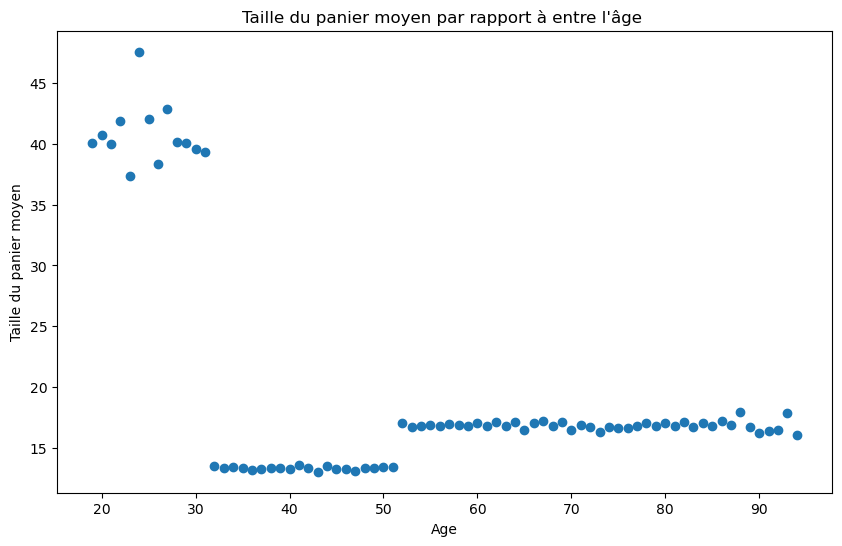

In [153]:
#Graphique de dispersion pour visualiser la relation entre l'âge et la taille du panier moyen
plt.figure(figsize=(10,6))
plt.scatter(panier_moyen['Âge'],panier_moyen['panier_moy'])
plt.xlabel('Age')
plt.ylabel('Taille du panier moyen')
plt.title('Taille du panier moyen par rapport à entre l\'âge ')
plt.show()

In [154]:
#Test de normalité de Kolmogorov-Smirnov pour l'âge
age = panier_moyen['Âge']
ks_statistic, p_value = stats.kstest(age, 'norm', args=(np.mean(age), np.std(age)))
print(f"Kolmogorov-Smirnov test pour l'âge: KS Statistic:{ks_statistic}, p-value:{p_value}")

if p_value < 0.05:
    print("La distribution ne suit pas une loi normale.")
else:
    print("La distribution suit une loi normale.")



#Test de normalité de Kolmogorov-Smirnov pour le montant des achats
panier_moyen1 = panier_moyen['panier_moy']
ks_statistic, p_value = stats.kstest(panier_moyen1, 'norm', args=(np.mean(panier_moyen1), np.std(panier_moyen1)))

print(f"Kolmogorov-Smirnov test pour le panier moyen: KS Statistic:{ks_statistic}, p-value:{p_value}")

if p_value < 0.05:
    print("La distribution ne suit pas une loi normale.")
else:
    print("La distribution suit une loi normale.")

Kolmogorov-Smirnov test pour l'âge: KS Statistic:0.0638004630812204, p-value:0.8968673444312906
La distribution suit une loi normale.
Kolmogorov-Smirnov test pour le panier moyen: KS Statistic:0.4168020864098373, p-value:1.7930023407909143e-12
La distribution ne suit pas une loi normale.


**Etant donné que le panier moyen ne suit pas une distribution normale**, nous allons utiliser un **test non-parametrique** à savoir le **test de Spearman**.

In [155]:
panier_moyen

,Âge,panier_moy
0,19,40.044298
1,20,40.781442
2,21,40.018436
3,22,41.900423
4,23,37.352562
...,...,...
71,90,16.160977
72,91,16.394676
73,92,16.409695
74,93,17.834414


In [156]:
age = panier_moyen['Âge']
panier_moy = panier_moyen ['panier_moy']

#calcul du coefficient de corrélation de Spearman et p-value
correlation, p_value = stats.spearmanr(age, panier_moy)

#Affichage des résultats
print("Coefficient de corrélation r de spearman :", correlation)
print ("p-value :", p_value)

Coefficient de corrélation r de spearman : -0.08921394395078605
p-value : 0.4434446826629047


In [157]:
age =panier_moyen['Âge']
panier_moy = panier_moyen['panier_moy']

#Calcul du coefficient de corrélation de Pearson et p-value
correlation, p_value = stats.pearsonr(age, panier_moy)

#Affichage des résultats
print("Coefficient de corrélation de pearson :", correlation)
print("p-value :", p_value)



Coefficient de corrélation de pearson : -0.5474159286332789
p-value : 3.1002340772609103e-07


Le coefficient de corrélation est négatif, ce qui suggère une corrélation négative modérée entre l'âge et la taille du panier moyen.
Cela signifie que lorsque l'âge augmente, la taille du panier moyen tend donc à diminuer, et vice versa. \
Notre seuil alpha étant égal à 0.05, **p-value<0.05, nous ne pouvons pas rejeter notre hypothèse H0(absence de relation) alors nous pouvons considérer qu'il y a une relation entre l'âge et la taille du panier moyen.**

En regardant la taille moyenne du panier par age, on constate des regroupements significatifs:
    

la tranche 18-32 achète avec un panier de taille moyenne entre 1,5 et 2 articles

la tranche 32-52: environ 2,4 articles en moyenne.
    
la tranche plus de 50 ans entre 1,2 et 1,6 articles en moyenne.

### Lien entre l'âge et les catégories de livres achetés


Nous avons une variable quantitative (âge) et une variable qualitative (catégorie des produits achetés), nous ferons une visualisation avec des boites à moustaches.

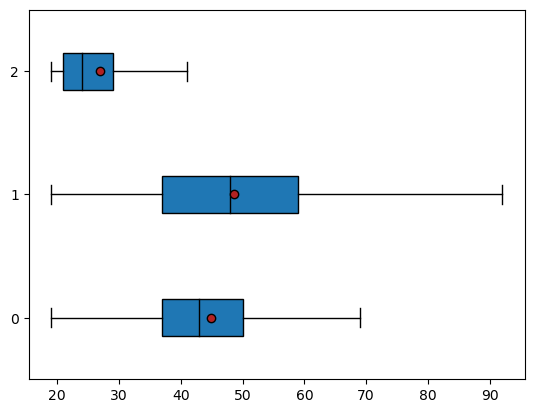

In [158]:
X = "categ" # qualitative
Y = "Âge" # quantitative

sous_echantillon = df_complet.copy() # on utilise comme sous-échantillon, les données complètes
#Affichage du graphique
modalites = sous_echantillon[X].unique()
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()


Selon le graphe, on visualise que la catégorie 2 est achetée uniquement par les moins de 40 ans; et que la catégorie 0 par les moins de 70 ans ==> il semble exister un lien entre l'age et la catégorie de livres achetés. Nous sommes dans le cas d'une variable qualitative et d'une variable quantitative, nous allons donc voir s'il faudra faire le test d'ANOVA.

Le test ANOVA consiste à vérifier l'égalité des moyennes,

soit H0, les moyennes des ages sont égales quelque soit la catégorie.
H1, les moyennes ne sont pas égales, il y a donc un lien entre la catégorie et l'age.

Ce test applicable uniquement dans les conditions où:

variances égales
indépendance entre les echantillons.


Les données âge et catégorie ont été collectées de façon indépendante, 2 fichiers produit et client. Vérifions l'égalité des variances:



In [451]:
import scipy.stats as st
from scipy.stats import norm, kstest

In [452]:
#Hypothèses:
#H0: La variable dont provient l'échantillon suit une loi Normale
#H1: La variable dont provient l'échantillon ne suit pas une loi Normale.

#test de normalité pour chaque catégorie de livres
categories = df_complet.copy()['categ'].unique()

for category in categories:
    # Extraire les âges pour la catégorie donnée
    ages = df_complet.copy()[df_complet.copy()['categ'] == category]['Âge']
   
    #Effectuer le test de normalité (par exemple, test de Shapiro-Wilk)
    statistic, p_value = st.shapiro(ages)
   
    #Afficher les résultats
    print(f"Catégorie {category}:")
    print("Statistique de test :", statistic)
    print("Valeur p :", p_value)
    print()

Catégorie 0:
Statistique de test : 0.9358228445053101
Valeur p : 0.0

Catégorie 1:
Statistique de test : 0.9892889261245728
Valeur p : 0.0

Catégorie 2:
Statistique de test : 0.6674748659133911
Valeur p : 0.0




Interpretation du test: 

Etant donné que la p-value<0.05, on rejète l'hypothèse nulle H0, et on retient l'hypothèse alternative H1.\
Ainsi nous pouvons dire que la variable âge ne suit pas une distribution normale dans chaque catégorie, nous allons alors faire un test de kruskal-wallis.

In [171]:
from scipy.stats import kruskal


In [172]:
# création d'une liste vide pour stocker les données d'âge pour chaque catégorie
groupes = []

# dans la variable "catégories uniques" extraction des données d'âge pour chaque catégorie
catégories_uniques = df_complet['categ'].unique()
for catégorie in catégories_uniques:
    groupe = df_complet[df_complet['categ'] == catégorie]['Âge']
    groupes.append(groupe)
    
# Test de kruskal-wallis
statistique_age_genre, p_value_age_genre = kruskal(*groupes)

# Résultats
print("statistique du test de kruskal-wallis :", statistique_age_genre)
print("valeur de p (p_value) :", p_value_age_genre)

# Interprétation des résultatsen fonction de la valeur p (p_value) pour déterminer la significativité statistique
if p_value < 0.05 :
    print("il existe des différences statistiquement significatives entre au moins deux groupes.")
else :
    print("il n'y a pas de différences statistiquement significatives entre les groupes.")

statistique du test de kruskal-wallis : 76847.37267274888
valeur de p (p_value) : 0.0
il existe des différences statistiquement significatives entre au moins deux groupes.
